# Miller age

In [1]:
ood_seed = 7

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Hub cells', '15.0'), 308)


Removed datapoint: 308

train         5698
validation    1399
ood            308
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 80942.21it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 983683.45it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 204.98it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:03<20:08,  3.03s/it]

Epoch 1/400:   0%|          | 1/400 [00:03<20:08,  3.03s/it, v_num=1, recon=1.22e+3, r2_mean=0.0606, adv_loss=3.44, acc_pert=0.311, acc_integration_donor=0.14]

Epoch 2/400:   0%|          | 1/400 [00:03<20:08,  3.03s/it, v_num=1, recon=1.22e+3, r2_mean=0.0606, adv_loss=3.44, acc_pert=0.311, acc_integration_donor=0.14]

Epoch 2/400:   0%|          | 2/400 [00:05<18:29,  2.79s/it, v_num=1, recon=1.22e+3, r2_mean=0.0606, adv_loss=3.44, acc_pert=0.311, acc_integration_donor=0.14]

Epoch 2/400:   0%|          | 2/400 [00:05<18:29,  2.79s/it, v_num=1, recon=1.03e+3, r2_mean=0.288, adv_loss=3.07, acc_pert=0.463, acc_integration_donor=0.288]

Epoch 3/400:   0%|          | 2/400 [00:05<18:29,  2.79s/it, v_num=1, recon=1.03e+3, r2_mean=0.288, adv_loss=3.07, acc_pert=0.463, acc_integration_donor=0.288]

Epoch 3/400:   1%|          | 3/400 [00:08<17:53,  2.70s/it, v_num=1, recon=1.03e+3, r2_mean=0.288, adv_loss=3.07, acc_pert=0.463, acc_integration_donor=0.288]

Epoch 3/400:   1%|          | 3/400 [00:08<17:53,  2.70s/it, v_num=1, recon=953, r2_mean=0.391, adv_loss=2.68, acc_pert=0.567, acc_integration_donor=0.45]     

Epoch 4/400:   1%|          | 3/400 [00:08<17:53,  2.70s/it, v_num=1, recon=953, r2_mean=0.391, adv_loss=2.68, acc_pert=0.567, acc_integration_donor=0.45]

Epoch 4/400:   1%|          | 4/400 [00:10<17:46,  2.69s/it, v_num=1, recon=953, r2_mean=0.391, adv_loss=2.68, acc_pert=0.567, acc_integration_donor=0.45]

Epoch 4/400:   1%|          | 4/400 [00:10<17:46,  2.69s/it, v_num=1, recon=917, r2_mean=0.439, adv_loss=2.47, acc_pert=0.56, acc_integration_donor=0.497]

Epoch 5/400:   1%|          | 4/400 [00:10<17:46,  2.69s/it, v_num=1, recon=917, r2_mean=0.439, adv_loss=2.47, acc_pert=0.56, acc_integration_donor=0.497]

Epoch 5/400:   1%|▏         | 5/400 [00:13<17:31,  2.66s/it, v_num=1, recon=917, r2_mean=0.439, adv_loss=2.47, acc_pert=0.56, acc_integration_donor=0.497]

Epoch 5/400:   1%|▏         | 5/400 [00:13<17:31,  2.66s/it, v_num=1, recon=900, r2_mean=0.46, adv_loss=2.34, acc_pert=0.567, acc_integration_donor=0.532]

Epoch 6/400:   1%|▏         | 5/400 [00:13<17:31,  2.66s/it, v_num=1, recon=900, r2_mean=0.46, adv_loss=2.34, acc_pert=0.567, acc_integration_donor=0.532]

Epoch 6/400:   2%|▏         | 6/400 [00:16<17:33,  2.67s/it, v_num=1, recon=900, r2_mean=0.46, adv_loss=2.34, acc_pert=0.567, acc_integration_donor=0.532]

Epoch 6/400:   2%|▏         | 6/400 [00:16<17:33,  2.67s/it, v_num=1, recon=887, r2_mean=0.475, adv_loss=2.25, acc_pert=0.556, acc_integration_donor=0.55]

Epoch 7/400:   2%|▏         | 6/400 [00:16<17:33,  2.67s/it, v_num=1, recon=887, r2_mean=0.475, adv_loss=2.25, acc_pert=0.556, acc_integration_donor=0.55]

Epoch 7/400:   2%|▏         | 7/400 [00:18<17:26,  2.66s/it, v_num=1, recon=887, r2_mean=0.475, adv_loss=2.25, acc_pert=0.556, acc_integration_donor=0.55]

Epoch 7/400:   2%|▏         | 7/400 [00:18<17:26,  2.66s/it, v_num=1, recon=877, r2_mean=0.477, adv_loss=2.2, acc_pert=0.553, acc_integration_donor=0.561]

Epoch 8/400:   2%|▏         | 7/400 [00:18<17:26,  2.66s/it, v_num=1, recon=877, r2_mean=0.477, adv_loss=2.2, acc_pert=0.553, acc_integration_donor=0.561]

Epoch 8/400:   2%|▏         | 8/400 [00:21<17:14,  2.64s/it, v_num=1, recon=877, r2_mean=0.477, adv_loss=2.2, acc_pert=0.553, acc_integration_donor=0.561]

Epoch 8/400:   2%|▏         | 8/400 [00:21<17:14,  2.64s/it, v_num=1, recon=871, r2_mean=0.487, adv_loss=2.22, acc_pert=0.501, acc_integration_donor=0.549]

Epoch 9/400:   2%|▏         | 8/400 [00:21<17:14,  2.64s/it, v_num=1, recon=871, r2_mean=0.487, adv_loss=2.22, acc_pert=0.501, acc_integration_donor=0.549]

Epoch 9/400:   2%|▏         | 9/400 [00:24<17:04,  2.62s/it, v_num=1, recon=871, r2_mean=0.487, adv_loss=2.22, acc_pert=0.501, acc_integration_donor=0.549]

Epoch 9/400:   2%|▏         | 9/400 [00:24<17:04,  2.62s/it, v_num=1, recon=864, r2_mean=0.485, adv_loss=2.23, acc_pert=0.522, acc_integration_donor=0.536]

Epoch 10/400:   2%|▏         | 9/400 [00:24<17:04,  2.62s/it, v_num=1, recon=864, r2_mean=0.485, adv_loss=2.23, acc_pert=0.522, acc_integration_donor=0.536]


disnt_basal = 0.5538577212812268

disnt_after = 1.0189966674770632

val_r2_mean = 0.5235572872417315

val_r2_var = 0.18034904295360887


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:32<29:24,  4.52s/it, v_num=1, recon=864, r2_mean=0.485, adv_loss=2.23, acc_pert=0.522, acc_integration_donor=0.536]

Epoch 10/400:   2%|▎         | 10/400 [00:32<29:24,  4.52s/it, v_num=1, recon=860, r2_mean=0.499, adv_loss=2.19, acc_pert=0.529, acc_integration_donor=0.537, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:32<29:24,  4.52s/it, v_num=1, recon=860, r2_mean=0.499, adv_loss=2.19, acc_pert=0.529, acc_integration_donor=0.537, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:35<25:41,  3.96s/it, v_num=1, recon=860, r2_mean=0.499, adv_loss=2.19, acc_pert=0.529, acc_integration_donor=0.537, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:35<25:41,  3.96s/it, v_num=1, recon=856, r2_mean=0.504, adv_loss=2.14, acc_pert=0.536, acc_integration_donor=0.539, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:35<25:41,  3.96s/it, v_num=1, recon=856, r2_mean=0.504, adv_loss=2.14, acc_pert=0.536, acc_integration_donor=0.539, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:39<26:25,  4.09s/it, v_num=1, recon=856, r2_mean=0.504, adv_loss=2.14, acc_pert=0.536, acc_integration_donor=0.539, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:39<26:25,  4.09s/it, v_num=1, recon=852, r2_mean=0.511, adv_loss=2.13, acc_pert=0.54, acc_integration_donor=0.532, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan] 

Epoch 13/400:   3%|▎         | 12/400 [00:39<26:25,  4.09s/it, v_num=1, recon=852, r2_mean=0.511, adv_loss=2.13, acc_pert=0.54, acc_integration_donor=0.532, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:42<23:19,  3.62s/it, v_num=1, recon=852, r2_mean=0.511, adv_loss=2.13, acc_pert=0.54, acc_integration_donor=0.532, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:42<23:19,  3.62s/it, v_num=1, recon=848, r2_mean=0.514, adv_loss=2.11, acc_pert=0.539, acc_integration_donor=0.535, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:42<23:19,  3.62s/it, v_num=1, recon=848, r2_mean=0.514, adv_loss=2.11, acc_pert=0.539, acc_integration_donor=0.535, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:44<21:08,  3.29s/it, v_num=1, recon=848, r2_mean=0.514, adv_loss=2.11, acc_pert=0.539, acc_integration_donor=0.535, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:44<21:08,  3.29s/it, v_num=1, recon=846, r2_mean=0.518, adv_loss=2.13, acc_pert=0.545, acc_integration_donor=0.534, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:44<21:08,  3.29s/it, v_num=1, recon=846, r2_mean=0.518, adv_loss=2.13, acc_pert=0.545, acc_integration_donor=0.534, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:47<19:36,  3.06s/it, v_num=1, recon=846, r2_mean=0.518, adv_loss=2.13, acc_pert=0.545, acc_integration_donor=0.534, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:47<19:36,  3.06s/it, v_num=1, recon=841, r2_mean=0.525, adv_loss=2.12, acc_pert=0.551, acc_integration_donor=0.524, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [00:47<19:36,  3.06s/it, v_num=1, recon=841, r2_mean=0.525, adv_loss=2.12, acc_pert=0.551, acc_integration_donor=0.524, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:50<18:38,  2.91s/it, v_num=1, recon=841, r2_mean=0.525, adv_loss=2.12, acc_pert=0.551, acc_integration_donor=0.524, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:50<18:38,  2.91s/it, v_num=1, recon=839, r2_mean=0.524, adv_loss=2.15, acc_pert=0.548, acc_integration_donor=0.52, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan] 

Epoch 17/400:   4%|▍         | 16/400 [00:50<18:38,  2.91s/it, v_num=1, recon=839, r2_mean=0.524, adv_loss=2.15, acc_pert=0.548, acc_integration_donor=0.52, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:52<17:53,  2.80s/it, v_num=1, recon=839, r2_mean=0.524, adv_loss=2.15, acc_pert=0.548, acc_integration_donor=0.52, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:52<17:53,  2.80s/it, v_num=1, recon=836, r2_mean=0.529, adv_loss=2.16, acc_pert=0.546, acc_integration_donor=0.523, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:52<17:53,  2.80s/it, v_num=1, recon=836, r2_mean=0.529, adv_loss=2.16, acc_pert=0.546, acc_integration_donor=0.523, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:55<17:32,  2.75s/it, v_num=1, recon=836, r2_mean=0.529, adv_loss=2.16, acc_pert=0.546, acc_integration_donor=0.523, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:55<17:32,  2.75s/it, v_num=1, recon=833, r2_mean=0.53, adv_loss=2.15, acc_pert=0.557, acc_integration_donor=0.524, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan] 

Epoch 19/400:   4%|▍         | 18/400 [00:55<17:32,  2.75s/it, v_num=1, recon=833, r2_mean=0.53, adv_loss=2.15, acc_pert=0.557, acc_integration_donor=0.524, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:57<17:06,  2.69s/it, v_num=1, recon=833, r2_mean=0.53, adv_loss=2.15, acc_pert=0.557, acc_integration_donor=0.524, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:57<17:06,  2.69s/it, v_num=1, recon=831, r2_mean=0.529, adv_loss=2.18, acc_pert=0.546, acc_integration_donor=0.516, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [00:57<17:06,  2.69s/it, v_num=1, recon=831, r2_mean=0.529, adv_loss=2.18, acc_pert=0.546, acc_integration_donor=0.516, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]


disnt_basal = 0.5195731504845184

disnt_after = 0.9395176716897164

val_r2_mean = 0.5175416345720167

val_r2_var = 0.3167712315917015

Epoch 20/400:   5%|▌         | 20/400 [01:08<32:55,  5.20s/it, v_num=1, recon=831, r2_mean=0.529, adv_loss=2.18, acc_pert=0.546, acc_integration_donor=0.516, val_recon=843, disnt_basal=0.554, disnt_after=1.02, val_r2_mean=0.524, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:08<32:55,  5.20s/it, v_num=1, recon=829, r2_mean=0.54, adv_loss=2.18, acc_pert=0.545, acc_integration_donor=0.526, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]  

Epoch 21/400:   5%|▌         | 20/400 [01:08<32:55,  5.20s/it, v_num=1, recon=829, r2_mean=0.54, adv_loss=2.18, acc_pert=0.545, acc_integration_donor=0.526, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:13<31:44,  5.02s/it, v_num=1, recon=829, r2_mean=0.54, adv_loss=2.18, acc_pert=0.545, acc_integration_donor=0.526, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:13<31:44,  5.02s/it, v_num=1, recon=828, r2_mean=0.541, adv_loss=2.21, acc_pert=0.534, acc_integration_donor=0.522, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:13<31:44,  5.02s/it, v_num=1, recon=828, r2_mean=0.541, adv_loss=2.21, acc_pert=0.534, acc_integration_donor=0.522, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:15<26:57,  4.28s/it, v_num=1, recon=828, r2_mean=0.541, adv_loss=2.21, acc_pert=0.534, acc_integration_donor=0.522, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:15<26:57,  4.28s/it, v_num=1, recon=826, r2_mean=0.543, adv_loss=2.2, acc_pert=0.54, acc_integration_donor=0.518, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]  

Epoch 23/400:   6%|▌         | 22/400 [01:15<26:57,  4.28s/it, v_num=1, recon=826, r2_mean=0.543, adv_loss=2.2, acc_pert=0.54, acc_integration_donor=0.518, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:18<23:49,  3.79s/it, v_num=1, recon=826, r2_mean=0.543, adv_loss=2.2, acc_pert=0.54, acc_integration_donor=0.518, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:18<23:49,  3.79s/it, v_num=1, recon=824, r2_mean=0.541, adv_loss=2.21, acc_pert=0.542, acc_integration_donor=0.516, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:18<23:49,  3.79s/it, v_num=1, recon=824, r2_mean=0.541, adv_loss=2.21, acc_pert=0.542, acc_integration_donor=0.516, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:21<21:36,  3.45s/it, v_num=1, recon=824, r2_mean=0.541, adv_loss=2.21, acc_pert=0.542, acc_integration_donor=0.516, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:21<21:36,  3.45s/it, v_num=1, recon=822, r2_mean=0.547, adv_loss=2.23, acc_pert=0.524, acc_integration_donor=0.517, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:21<21:36,  3.45s/it, v_num=1, recon=822, r2_mean=0.547, adv_loss=2.23, acc_pert=0.524, acc_integration_donor=0.517, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:23<20:03,  3.21s/it, v_num=1, recon=822, r2_mean=0.547, adv_loss=2.23, acc_pert=0.524, acc_integration_donor=0.517, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:23<20:03,  3.21s/it, v_num=1, recon=821, r2_mean=0.547, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.508, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:23<20:03,  3.21s/it, v_num=1, recon=821, r2_mean=0.547, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.508, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:26<18:42,  3.00s/it, v_num=1, recon=821, r2_mean=0.547, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.508, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:26<18:42,  3.00s/it, v_num=1, recon=819, r2_mean=0.552, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.513, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:26<18:42,  3.00s/it, v_num=1, recon=819, r2_mean=0.552, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.513, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:29<18:00,  2.90s/it, v_num=1, recon=819, r2_mean=0.552, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.513, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:29<18:00,  2.90s/it, v_num=1, recon=817, r2_mean=0.549, adv_loss=2.32, acc_pert=0.497, acc_integration_donor=0.518, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:29<18:00,  2.90s/it, v_num=1, recon=817, r2_mean=0.549, adv_loss=2.32, acc_pert=0.497, acc_integration_donor=0.518, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:31<17:16,  2.79s/it, v_num=1, recon=817, r2_mean=0.549, adv_loss=2.32, acc_pert=0.497, acc_integration_donor=0.518, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:31<17:16,  2.79s/it, v_num=1, recon=816, r2_mean=0.547, adv_loss=2.29, acc_pert=0.502, acc_integration_donor=0.526, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:31<17:16,  2.79s/it, v_num=1, recon=816, r2_mean=0.547, adv_loss=2.29, acc_pert=0.502, acc_integration_donor=0.526, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:34<16:51,  2.73s/it, v_num=1, recon=816, r2_mean=0.547, adv_loss=2.29, acc_pert=0.502, acc_integration_donor=0.526, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:34<16:51,  2.73s/it, v_num=1, recon=815, r2_mean=0.553, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.516, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan] 

Epoch 30/400:   7%|▋         | 29/400 [01:34<16:51,  2.73s/it, v_num=1, recon=815, r2_mean=0.553, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.516, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]


disnt_basal = 0.4981974385649558

disnt_after = 0.9396795045501957

val_r2_mean = 0.5272759263004576

val_r2_var = 0.3563093547890713


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:49<39:16,  6.37s/it, v_num=1, recon=815, r2_mean=0.553, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.516, val_recon=813, disnt_basal=0.52, disnt_after=0.94, val_r2_mean=0.518, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:49<39:16,  6.37s/it, v_num=1, recon=814, r2_mean=0.555, adv_loss=2.32, acc_pert=0.496, acc_integration_donor=0.517, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:49<39:16,  6.37s/it, v_num=1, recon=814, r2_mean=0.555, adv_loss=2.32, acc_pert=0.496, acc_integration_donor=0.517, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:51<32:08,  5.23s/it, v_num=1, recon=814, r2_mean=0.555, adv_loss=2.32, acc_pert=0.496, acc_integration_donor=0.517, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:51<32:08,  5.23s/it, v_num=1, recon=812, r2_mean=0.56, adv_loss=2.33, acc_pert=0.485, acc_integration_donor=0.526, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan] 

Epoch 32/400:   8%|▊         | 31/400 [01:51<32:08,  5.23s/it, v_num=1, recon=812, r2_mean=0.56, adv_loss=2.33, acc_pert=0.485, acc_integration_donor=0.526, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:54<27:21,  4.46s/it, v_num=1, recon=812, r2_mean=0.56, adv_loss=2.33, acc_pert=0.485, acc_integration_donor=0.526, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:54<27:21,  4.46s/it, v_num=1, recon=811, r2_mean=0.553, adv_loss=2.32, acc_pert=0.491, acc_integration_donor=0.523, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [01:54<27:21,  4.46s/it, v_num=1, recon=811, r2_mean=0.553, adv_loss=2.32, acc_pert=0.491, acc_integration_donor=0.523, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:56<23:56,  3.92s/it, v_num=1, recon=811, r2_mean=0.553, adv_loss=2.32, acc_pert=0.491, acc_integration_donor=0.523, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:56<23:56,  3.92s/it, v_num=1, recon=811, r2_mean=0.559, adv_loss=2.33, acc_pert=0.485, acc_integration_donor=0.519, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [01:56<23:56,  3.92s/it, v_num=1, recon=811, r2_mean=0.559, adv_loss=2.33, acc_pert=0.485, acc_integration_donor=0.519, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:59<21:29,  3.52s/it, v_num=1, recon=811, r2_mean=0.559, adv_loss=2.33, acc_pert=0.485, acc_integration_donor=0.519, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:59<21:29,  3.52s/it, v_num=1, recon=809, r2_mean=0.56, adv_loss=2.36, acc_pert=0.478, acc_integration_donor=0.517, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan] 

Epoch 35/400:   8%|▊         | 34/400 [01:59<21:29,  3.52s/it, v_num=1, recon=809, r2_mean=0.56, adv_loss=2.36, acc_pert=0.478, acc_integration_donor=0.517, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:02<19:42,  3.24s/it, v_num=1, recon=809, r2_mean=0.56, adv_loss=2.36, acc_pert=0.478, acc_integration_donor=0.517, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:02<19:42,  3.24s/it, v_num=1, recon=808, r2_mean=0.557, adv_loss=2.35, acc_pert=0.476, acc_integration_donor=0.51, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [02:02<19:42,  3.24s/it, v_num=1, recon=808, r2_mean=0.557, adv_loss=2.35, acc_pert=0.476, acc_integration_donor=0.51, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:04<18:23,  3.03s/it, v_num=1, recon=808, r2_mean=0.557, adv_loss=2.35, acc_pert=0.476, acc_integration_donor=0.51, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:04<18:23,  3.03s/it, v_num=1, recon=809, r2_mean=0.558, adv_loss=2.37, acc_pert=0.475, acc_integration_donor=0.516, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [02:04<18:23,  3.03s/it, v_num=1, recon=809, r2_mean=0.558, adv_loss=2.37, acc_pert=0.475, acc_integration_donor=0.516, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:07<17:31,  2.90s/it, v_num=1, recon=809, r2_mean=0.558, adv_loss=2.37, acc_pert=0.475, acc_integration_donor=0.516, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:07<17:31,  2.90s/it, v_num=1, recon=805, r2_mean=0.566, adv_loss=2.37, acc_pert=0.477, acc_integration_donor=0.513, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [02:07<17:31,  2.90s/it, v_num=1, recon=805, r2_mean=0.566, adv_loss=2.37, acc_pert=0.477, acc_integration_donor=0.513, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:09<16:55,  2.80s/it, v_num=1, recon=805, r2_mean=0.566, adv_loss=2.37, acc_pert=0.477, acc_integration_donor=0.513, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:09<16:55,  2.80s/it, v_num=1, recon=806, r2_mean=0.561, adv_loss=2.37, acc_pert=0.465, acc_integration_donor=0.512, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [02:09<16:55,  2.80s/it, v_num=1, recon=806, r2_mean=0.561, adv_loss=2.37, acc_pert=0.465, acc_integration_donor=0.512, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:12<16:22,  2.72s/it, v_num=1, recon=806, r2_mean=0.561, adv_loss=2.37, acc_pert=0.465, acc_integration_donor=0.512, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:12<16:22,  2.72s/it, v_num=1, recon=803, r2_mean=0.562, adv_loss=2.37, acc_pert=0.469, acc_integration_donor=0.513, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [02:12<16:22,  2.72s/it, v_num=1, recon=803, r2_mean=0.562, adv_loss=2.37, acc_pert=0.469, acc_integration_donor=0.513, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]


disnt_basal = 0.48646871038575606

disnt_after = 0.9445800152223464

val_r2_mean = 0.5323382860847882

val_r2_var = 0.3555750113416028


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [02:28<40:45,  6.79s/it, v_num=1, recon=803, r2_mean=0.562, adv_loss=2.37, acc_pert=0.469, acc_integration_donor=0.513, val_recon=804, disnt_basal=0.498, disnt_after=0.94, val_r2_mean=0.527, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [02:28<40:45,  6.79s/it, v_num=1, recon=801, r2_mean=0.565, adv_loss=2.37, acc_pert=0.465, acc_integration_donor=0.514, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [02:28<40:45,  6.79s/it, v_num=1, recon=801, r2_mean=0.565, adv_loss=2.37, acc_pert=0.465, acc_integration_donor=0.514, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:31<33:16,  5.56s/it, v_num=1, recon=801, r2_mean=0.565, adv_loss=2.37, acc_pert=0.465, acc_integration_donor=0.514, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:31<33:16,  5.56s/it, v_num=1, recon=801, r2_mean=0.57, adv_loss=2.39, acc_pert=0.469, acc_integration_donor=0.507, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan] 

Epoch 42/400:  10%|█         | 41/400 [02:31<33:16,  5.56s/it, v_num=1, recon=801, r2_mean=0.57, adv_loss=2.39, acc_pert=0.469, acc_integration_donor=0.507, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:33<27:48,  4.66s/it, v_num=1, recon=801, r2_mean=0.57, adv_loss=2.39, acc_pert=0.469, acc_integration_donor=0.507, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:33<27:48,  4.66s/it, v_num=1, recon=800, r2_mean=0.563, adv_loss=2.39, acc_pert=0.462, acc_integration_donor=0.508, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [02:33<27:48,  4.66s/it, v_num=1, recon=800, r2_mean=0.563, adv_loss=2.39, acc_pert=0.462, acc_integration_donor=0.508, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:36<23:58,  4.03s/it, v_num=1, recon=800, r2_mean=0.563, adv_loss=2.39, acc_pert=0.462, acc_integration_donor=0.508, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:36<23:58,  4.03s/it, v_num=1, recon=800, r2_mean=0.567, adv_loss=2.38, acc_pert=0.471, acc_integration_donor=0.51, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan] 

Epoch 44/400:  11%|█         | 43/400 [02:36<23:58,  4.03s/it, v_num=1, recon=800, r2_mean=0.567, adv_loss=2.38, acc_pert=0.471, acc_integration_donor=0.51, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:39<21:30,  3.63s/it, v_num=1, recon=800, r2_mean=0.567, adv_loss=2.38, acc_pert=0.471, acc_integration_donor=0.51, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:39<21:30,  3.63s/it, v_num=1, recon=800, r2_mean=0.567, adv_loss=2.4, acc_pert=0.471, acc_integration_donor=0.501, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [02:39<21:30,  3.63s/it, v_num=1, recon=800, r2_mean=0.567, adv_loss=2.4, acc_pert=0.471, acc_integration_donor=0.501, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:41<19:39,  3.32s/it, v_num=1, recon=800, r2_mean=0.567, adv_loss=2.4, acc_pert=0.471, acc_integration_donor=0.501, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:41<19:39,  3.32s/it, v_num=1, recon=799, r2_mean=0.568, adv_loss=2.39, acc_pert=0.467, acc_integration_donor=0.509, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [02:41<19:39,  3.32s/it, v_num=1, recon=799, r2_mean=0.568, adv_loss=2.39, acc_pert=0.467, acc_integration_donor=0.509, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:44<18:10,  3.08s/it, v_num=1, recon=799, r2_mean=0.568, adv_loss=2.39, acc_pert=0.467, acc_integration_donor=0.509, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:44<18:10,  3.08s/it, v_num=1, recon=797, r2_mean=0.567, adv_loss=2.42, acc_pert=0.46, acc_integration_donor=0.501, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan] 

Epoch 47/400:  12%|█▏        | 46/400 [02:44<18:10,  3.08s/it, v_num=1, recon=797, r2_mean=0.567, adv_loss=2.42, acc_pert=0.46, acc_integration_donor=0.501, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:47<17:26,  2.96s/it, v_num=1, recon=797, r2_mean=0.567, adv_loss=2.42, acc_pert=0.46, acc_integration_donor=0.501, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:47<17:26,  2.96s/it, v_num=1, recon=795, r2_mean=0.572, adv_loss=2.41, acc_pert=0.459, acc_integration_donor=0.502, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [02:47<17:26,  2.96s/it, v_num=1, recon=795, r2_mean=0.572, adv_loss=2.41, acc_pert=0.459, acc_integration_donor=0.502, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:49<16:42,  2.85s/it, v_num=1, recon=795, r2_mean=0.572, adv_loss=2.41, acc_pert=0.459, acc_integration_donor=0.502, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:49<16:42,  2.85s/it, v_num=1, recon=794, r2_mean=0.568, adv_loss=2.41, acc_pert=0.459, acc_integration_donor=0.507, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [02:49<16:42,  2.85s/it, v_num=1, recon=794, r2_mean=0.568, adv_loss=2.41, acc_pert=0.459, acc_integration_donor=0.507, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:52<16:12,  2.77s/it, v_num=1, recon=794, r2_mean=0.568, adv_loss=2.41, acc_pert=0.459, acc_integration_donor=0.507, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:52<16:12,  2.77s/it, v_num=1, recon=793, r2_mean=0.574, adv_loss=2.45, acc_pert=0.46, acc_integration_donor=0.499, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan] 

Epoch 50/400:  12%|█▏        | 49/400 [02:52<16:12,  2.77s/it, v_num=1, recon=793, r2_mean=0.574, adv_loss=2.45, acc_pert=0.46, acc_integration_donor=0.499, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]


disnt_basal = 0.45758296344237875

disnt_after = 0.9280762385253545

val_r2_mean = 0.5172090619415431

val_r2_var = 0.37551390137765317


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [03:00<25:11,  4.32s/it, v_num=1, recon=793, r2_mean=0.574, adv_loss=2.45, acc_pert=0.46, acc_integration_donor=0.499, val_recon=801, disnt_basal=0.486, disnt_after=0.945, val_r2_mean=0.532, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [03:00<25:11,  4.32s/it, v_num=1, recon=793, r2_mean=0.576, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.503, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [03:00<25:11,  4.32s/it, v_num=1, recon=793, r2_mean=0.576, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.503, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [03:02<22:11,  3.81s/it, v_num=1, recon=793, r2_mean=0.576, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.503, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [03:02<22:11,  3.81s/it, v_num=1, recon=791, r2_mean=0.58, adv_loss=2.44, acc_pert=0.466, acc_integration_donor=0.493, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [03:02<22:11,  3.81s/it, v_num=1, recon=791, r2_mean=0.58, adv_loss=2.44, acc_pert=0.466, acc_integration_donor=0.493, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [03:05<20:07,  3.47s/it, v_num=1, recon=791, r2_mean=0.58, adv_loss=2.44, acc_pert=0.466, acc_integration_donor=0.493, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [03:05<20:07,  3.47s/it, v_num=1, recon=791, r2_mean=0.572, adv_loss=2.45, acc_pert=0.452, acc_integration_donor=0.502, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [03:05<20:07,  3.47s/it, v_num=1, recon=791, r2_mean=0.572, adv_loss=2.45, acc_pert=0.452, acc_integration_donor=0.502, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:08<18:34,  3.21s/it, v_num=1, recon=791, r2_mean=0.572, adv_loss=2.45, acc_pert=0.452, acc_integration_donor=0.502, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:08<18:34,  3.21s/it, v_num=1, recon=790, r2_mean=0.577, adv_loss=2.46, acc_pert=0.454, acc_integration_donor=0.507, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [03:08<18:34,  3.21s/it, v_num=1, recon=790, r2_mean=0.577, adv_loss=2.46, acc_pert=0.454, acc_integration_donor=0.507, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:10<17:30,  3.04s/it, v_num=1, recon=790, r2_mean=0.577, adv_loss=2.46, acc_pert=0.454, acc_integration_donor=0.507, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:10<17:30,  3.04s/it, v_num=1, recon=789, r2_mean=0.578, adv_loss=2.45, acc_pert=0.454, acc_integration_donor=0.501, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [03:10<17:30,  3.04s/it, v_num=1, recon=789, r2_mean=0.578, adv_loss=2.45, acc_pert=0.454, acc_integration_donor=0.501, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:13<16:44,  2.91s/it, v_num=1, recon=789, r2_mean=0.578, adv_loss=2.45, acc_pert=0.454, acc_integration_donor=0.501, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:13<16:44,  2.91s/it, v_num=1, recon=788, r2_mean=0.576, adv_loss=2.49, acc_pert=0.446, acc_integration_donor=0.489, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [03:13<16:44,  2.91s/it, v_num=1, recon=788, r2_mean=0.576, adv_loss=2.49, acc_pert=0.446, acc_integration_donor=0.489, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:15<16:11,  2.82s/it, v_num=1, recon=788, r2_mean=0.576, adv_loss=2.49, acc_pert=0.446, acc_integration_donor=0.489, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:15<16:11,  2.82s/it, v_num=1, recon=787, r2_mean=0.575, adv_loss=2.46, acc_pert=0.459, acc_integration_donor=0.499, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [03:15<16:11,  2.82s/it, v_num=1, recon=787, r2_mean=0.575, adv_loss=2.46, acc_pert=0.459, acc_integration_donor=0.499, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:18<15:39,  2.74s/it, v_num=1, recon=787, r2_mean=0.575, adv_loss=2.46, acc_pert=0.459, acc_integration_donor=0.499, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:18<15:39,  2.74s/it, v_num=1, recon=787, r2_mean=0.583, adv_loss=2.48, acc_pert=0.446, acc_integration_donor=0.497, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [03:18<15:39,  2.74s/it, v_num=1, recon=787, r2_mean=0.583, adv_loss=2.48, acc_pert=0.446, acc_integration_donor=0.497, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:21<15:28,  2.71s/it, v_num=1, recon=787, r2_mean=0.583, adv_loss=2.48, acc_pert=0.446, acc_integration_donor=0.497, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:21<15:28,  2.71s/it, v_num=1, recon=786, r2_mean=0.579, adv_loss=2.48, acc_pert=0.445, acc_integration_donor=0.492, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [03:21<15:28,  2.71s/it, v_num=1, recon=786, r2_mean=0.579, adv_loss=2.48, acc_pert=0.445, acc_integration_donor=0.492, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:23<15:23,  2.71s/it, v_num=1, recon=786, r2_mean=0.579, adv_loss=2.48, acc_pert=0.445, acc_integration_donor=0.492, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:23<15:23,  2.71s/it, v_num=1, recon=785, r2_mean=0.584, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.484, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [03:23<15:23,  2.71s/it, v_num=1, recon=785, r2_mean=0.584, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.484, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]


disnt_basal = 0.45676525120843176

disnt_after = 0.966079730475581

val_r2_mean = 0.5392195438216258

val_r2_var = 0.4021796897634283


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [03:36<31:59,  5.65s/it, v_num=1, recon=785, r2_mean=0.584, adv_loss=2.52, acc_pert=0.449, acc_integration_donor=0.484, val_recon=799, disnt_basal=0.458, disnt_after=0.928, val_r2_mean=0.517, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [03:36<31:59,  5.65s/it, v_num=1, recon=784, r2_mean=0.58, adv_loss=2.5, acc_pert=0.442, acc_integration_donor=0.494, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]  

Epoch 61/400:  15%|█▌        | 60/400 [03:36<31:59,  5.65s/it, v_num=1, recon=784, r2_mean=0.58, adv_loss=2.5, acc_pert=0.442, acc_integration_donor=0.494, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:41<30:21,  5.37s/it, v_num=1, recon=784, r2_mean=0.58, adv_loss=2.5, acc_pert=0.442, acc_integration_donor=0.494, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:41<30:21,  5.37s/it, v_num=1, recon=782, r2_mean=0.586, adv_loss=2.49, acc_pert=0.45, acc_integration_donor=0.492, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [03:41<30:21,  5.37s/it, v_num=1, recon=782, r2_mean=0.586, adv_loss=2.49, acc_pert=0.45, acc_integration_donor=0.492, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:43<25:40,  4.56s/it, v_num=1, recon=782, r2_mean=0.586, adv_loss=2.49, acc_pert=0.45, acc_integration_donor=0.492, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:43<25:40,  4.56s/it, v_num=1, recon=782, r2_mean=0.583, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.492, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [03:43<25:40,  4.56s/it, v_num=1, recon=782, r2_mean=0.583, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.492, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:46<22:10,  3.95s/it, v_num=1, recon=782, r2_mean=0.583, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.492, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:46<22:10,  3.95s/it, v_num=1, recon=783, r2_mean=0.586, adv_loss=2.52, acc_pert=0.451, acc_integration_donor=0.486, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [03:46<22:10,  3.95s/it, v_num=1, recon=783, r2_mean=0.586, adv_loss=2.52, acc_pert=0.451, acc_integration_donor=0.486, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:48<19:45,  3.53s/it, v_num=1, recon=783, r2_mean=0.586, adv_loss=2.52, acc_pert=0.451, acc_integration_donor=0.486, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:48<19:45,  3.53s/it, v_num=1, recon=780, r2_mean=0.587, adv_loss=2.53, acc_pert=0.448, acc_integration_donor=0.49, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan] 

Epoch 65/400:  16%|█▌        | 64/400 [03:48<19:45,  3.53s/it, v_num=1, recon=780, r2_mean=0.587, adv_loss=2.53, acc_pert=0.448, acc_integration_donor=0.49, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:51<18:10,  3.26s/it, v_num=1, recon=780, r2_mean=0.587, adv_loss=2.53, acc_pert=0.448, acc_integration_donor=0.49, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:51<18:10,  3.26s/it, v_num=1, recon=780, r2_mean=0.585, adv_loss=2.52, acc_pert=0.444, acc_integration_donor=0.484, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [03:51<18:10,  3.26s/it, v_num=1, recon=780, r2_mean=0.585, adv_loss=2.52, acc_pert=0.444, acc_integration_donor=0.484, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:53<17:05,  3.07s/it, v_num=1, recon=780, r2_mean=0.585, adv_loss=2.52, acc_pert=0.444, acc_integration_donor=0.484, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:54<17:05,  3.07s/it, v_num=1, recon=779, r2_mean=0.588, adv_loss=2.51, acc_pert=0.437, acc_integration_donor=0.494, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [03:54<17:05,  3.07s/it, v_num=1, recon=779, r2_mean=0.588, adv_loss=2.51, acc_pert=0.437, acc_integration_donor=0.494, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:56<16:15,  2.93s/it, v_num=1, recon=779, r2_mean=0.588, adv_loss=2.51, acc_pert=0.437, acc_integration_donor=0.494, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:56<16:15,  2.93s/it, v_num=1, recon=778, r2_mean=0.582, adv_loss=2.54, acc_pert=0.442, acc_integration_donor=0.492, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [03:56<16:15,  2.93s/it, v_num=1, recon=778, r2_mean=0.582, adv_loss=2.54, acc_pert=0.442, acc_integration_donor=0.492, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:59<15:43,  2.84s/it, v_num=1, recon=778, r2_mean=0.582, adv_loss=2.54, acc_pert=0.442, acc_integration_donor=0.492, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:59<15:43,  2.84s/it, v_num=1, recon=777, r2_mean=0.585, adv_loss=2.54, acc_pert=0.44, acc_integration_donor=0.486, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan] 

Epoch 69/400:  17%|█▋        | 68/400 [03:59<15:43,  2.84s/it, v_num=1, recon=777, r2_mean=0.585, adv_loss=2.54, acc_pert=0.44, acc_integration_donor=0.486, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [04:01<15:14,  2.76s/it, v_num=1, recon=777, r2_mean=0.585, adv_loss=2.54, acc_pert=0.44, acc_integration_donor=0.486, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [04:01<15:14,  2.76s/it, v_num=1, recon=776, r2_mean=0.589, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.486, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [04:01<15:14,  2.76s/it, v_num=1, recon=776, r2_mean=0.589, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.486, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]


disnt_basal = 0.44791350428622534

disnt_after = 0.9679427088568321

val_r2_mean = 0.5175976255884418

val_r2_var = 0.37980860674923117

Epoch 70/400:  18%|█▊        | 70/400 [04:13<30:02,  5.46s/it, v_num=1, recon=776, r2_mean=0.589, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.486, val_recon=798, disnt_basal=0.457, disnt_after=0.966, val_r2_mean=0.539, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [04:13<30:02,  5.46s/it, v_num=1, recon=775, r2_mean=0.588, adv_loss=2.53, acc_pert=0.443, acc_integration_donor=0.481, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [04:13<30:02,  5.46s/it, v_num=1, recon=775, r2_mean=0.588, adv_loss=2.53, acc_pert=0.443, acc_integration_donor=0.481, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:16<25:53,  4.72s/it, v_num=1, recon=775, r2_mean=0.588, adv_loss=2.53, acc_pert=0.443, acc_integration_donor=0.481, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:16<25:53,  4.72s/it, v_num=1, recon=774, r2_mean=0.593, adv_loss=2.5, acc_pert=0.445, acc_integration_donor=0.497, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan] 

Epoch 72/400:  18%|█▊        | 71/400 [04:16<25:53,  4.72s/it, v_num=1, recon=774, r2_mean=0.593, adv_loss=2.5, acc_pert=0.445, acc_integration_donor=0.497, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:19<22:44,  4.16s/it, v_num=1, recon=774, r2_mean=0.593, adv_loss=2.5, acc_pert=0.445, acc_integration_donor=0.497, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:19<22:44,  4.16s/it, v_num=1, recon=774, r2_mean=0.587, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.496, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [04:19<22:44,  4.16s/it, v_num=1, recon=774, r2_mean=0.587, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.496, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:22<20:21,  3.73s/it, v_num=1, recon=774, r2_mean=0.587, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.496, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:22<20:21,  3.73s/it, v_num=1, recon=773, r2_mean=0.586, adv_loss=2.55, acc_pert=0.438, acc_integration_donor=0.479, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [04:22<20:21,  3.73s/it, v_num=1, recon=773, r2_mean=0.586, adv_loss=2.55, acc_pert=0.438, acc_integration_donor=0.479, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:24<18:35,  3.42s/it, v_num=1, recon=773, r2_mean=0.586, adv_loss=2.55, acc_pert=0.438, acc_integration_donor=0.479, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:24<18:35,  3.42s/it, v_num=1, recon=772, r2_mean=0.59, adv_loss=2.55, acc_pert=0.429, acc_integration_donor=0.477, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan] 

Epoch 75/400:  18%|█▊        | 74/400 [04:24<18:35,  3.42s/it, v_num=1, recon=772, r2_mean=0.59, adv_loss=2.55, acc_pert=0.429, acc_integration_donor=0.477, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:27<17:12,  3.18s/it, v_num=1, recon=772, r2_mean=0.59, adv_loss=2.55, acc_pert=0.429, acc_integration_donor=0.477, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:27<17:12,  3.18s/it, v_num=1, recon=770, r2_mean=0.59, adv_loss=2.54, acc_pert=0.436, acc_integration_donor=0.486, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [04:27<17:12,  3.18s/it, v_num=1, recon=770, r2_mean=0.59, adv_loss=2.54, acc_pert=0.436, acc_integration_donor=0.486, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:30<16:35,  3.07s/it, v_num=1, recon=770, r2_mean=0.59, adv_loss=2.54, acc_pert=0.436, acc_integration_donor=0.486, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:30<16:35,  3.07s/it, v_num=1, recon=770, r2_mean=0.59, adv_loss=2.55, acc_pert=0.444, acc_integration_donor=0.486, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [04:30<16:35,  3.07s/it, v_num=1, recon=770, r2_mean=0.59, adv_loss=2.55, acc_pert=0.444, acc_integration_donor=0.486, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:32<15:41,  2.92s/it, v_num=1, recon=770, r2_mean=0.59, adv_loss=2.55, acc_pert=0.444, acc_integration_donor=0.486, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:32<15:41,  2.92s/it, v_num=1, recon=770, r2_mean=0.596, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.479, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [04:32<15:41,  2.92s/it, v_num=1, recon=770, r2_mean=0.596, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.479, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:35<15:11,  2.83s/it, v_num=1, recon=770, r2_mean=0.596, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.479, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:35<15:11,  2.83s/it, v_num=1, recon=770, r2_mean=0.589, adv_loss=2.56, acc_pert=0.427, acc_integration_donor=0.481, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [04:35<15:11,  2.83s/it, v_num=1, recon=770, r2_mean=0.589, adv_loss=2.56, acc_pert=0.427, acc_integration_donor=0.481, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:38<14:53,  2.78s/it, v_num=1, recon=770, r2_mean=0.589, adv_loss=2.56, acc_pert=0.427, acc_integration_donor=0.481, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:38<14:53,  2.78s/it, v_num=1, recon=768, r2_mean=0.591, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.483, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [04:38<14:53,  2.78s/it, v_num=1, recon=768, r2_mean=0.591, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.483, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]


disnt_basal = 0.435040791708009

disnt_after = 0.951541674659827

val_r2_mean = 0.5099732489748434

val_r2_var = 0.40235895392569626

Epoch 80/400:  20%|██        | 80/400 [04:55<38:52,  7.29s/it, v_num=1, recon=768, r2_mean=0.591, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.483, val_recon=799, disnt_basal=0.448, disnt_after=0.968, val_r2_mean=0.518, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [04:55<38:52,  7.29s/it, v_num=1, recon=767, r2_mean=0.591, adv_loss=2.55, acc_pert=0.431, acc_integration_donor=0.487, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [04:55<38:52,  7.29s/it, v_num=1, recon=767, r2_mean=0.591, adv_loss=2.55, acc_pert=0.431, acc_integration_donor=0.487, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:58<31:27,  5.92s/it, v_num=1, recon=767, r2_mean=0.591, adv_loss=2.55, acc_pert=0.431, acc_integration_donor=0.487, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:58<31:27,  5.92s/it, v_num=1, recon=766, r2_mean=0.588, adv_loss=2.55, acc_pert=0.438, acc_integration_donor=0.481, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [04:58<31:27,  5.92s/it, v_num=1, recon=766, r2_mean=0.588, adv_loss=2.55, acc_pert=0.438, acc_integration_donor=0.481, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [05:01<26:01,  4.91s/it, v_num=1, recon=766, r2_mean=0.588, adv_loss=2.55, acc_pert=0.438, acc_integration_donor=0.481, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [05:01<26:01,  4.91s/it, v_num=1, recon=766, r2_mean=0.597, adv_loss=2.55, acc_pert=0.437, acc_integration_donor=0.476, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [05:01<26:01,  4.91s/it, v_num=1, recon=766, r2_mean=0.597, adv_loss=2.55, acc_pert=0.437, acc_integration_donor=0.476, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [05:03<22:12,  4.20s/it, v_num=1, recon=766, r2_mean=0.597, adv_loss=2.55, acc_pert=0.437, acc_integration_donor=0.476, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [05:03<22:12,  4.20s/it, v_num=1, recon=765, r2_mean=0.592, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.487, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [05:03<22:12,  4.20s/it, v_num=1, recon=765, r2_mean=0.592, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.487, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [05:06<19:33,  3.71s/it, v_num=1, recon=765, r2_mean=0.592, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.487, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [05:06<19:33,  3.71s/it, v_num=1, recon=764, r2_mean=0.597, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.489, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [05:06<19:33,  3.71s/it, v_num=1, recon=764, r2_mean=0.597, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.489, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [05:09<17:50,  3.40s/it, v_num=1, recon=764, r2_mean=0.597, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.489, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [05:09<17:50,  3.40s/it, v_num=1, recon=764, r2_mean=0.595, adv_loss=2.51, acc_pert=0.451, acc_integration_donor=0.483, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [05:09<17:50,  3.40s/it, v_num=1, recon=764, r2_mean=0.595, adv_loss=2.51, acc_pert=0.451, acc_integration_donor=0.483, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [05:11<16:26,  3.14s/it, v_num=1, recon=764, r2_mean=0.595, adv_loss=2.51, acc_pert=0.451, acc_integration_donor=0.483, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [05:11<16:26,  3.14s/it, v_num=1, recon=763, r2_mean=0.595, adv_loss=2.55, acc_pert=0.449, acc_integration_donor=0.478, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [05:11<16:26,  3.14s/it, v_num=1, recon=763, r2_mean=0.595, adv_loss=2.55, acc_pert=0.449, acc_integration_donor=0.478, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [05:14<15:36,  2.99s/it, v_num=1, recon=763, r2_mean=0.595, adv_loss=2.55, acc_pert=0.449, acc_integration_donor=0.478, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [05:14<15:36,  2.99s/it, v_num=1, recon=762, r2_mean=0.601, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.486, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [05:14<15:36,  2.99s/it, v_num=1, recon=762, r2_mean=0.601, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.486, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [05:16<14:52,  2.86s/it, v_num=1, recon=762, r2_mean=0.601, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.486, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [05:16<14:52,  2.86s/it, v_num=1, recon=761, r2_mean=0.6, adv_loss=2.55, acc_pert=0.443, acc_integration_donor=0.482, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]  

Epoch 89/400:  22%|██▏       | 88/400 [05:16<14:52,  2.86s/it, v_num=1, recon=761, r2_mean=0.6, adv_loss=2.55, acc_pert=0.443, acc_integration_donor=0.482, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:19<14:17,  2.76s/it, v_num=1, recon=761, r2_mean=0.6, adv_loss=2.55, acc_pert=0.443, acc_integration_donor=0.482, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:19<14:17,  2.76s/it, v_num=1, recon=759, r2_mean=0.604, adv_loss=2.55, acc_pert=0.441, acc_integration_donor=0.483, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [05:19<14:17,  2.76s/it, v_num=1, recon=759, r2_mean=0.604, adv_loss=2.55, acc_pert=0.441, acc_integration_donor=0.483, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]


disnt_basal = 0.4334552369662056

disnt_after = 0.9597377035073652

val_r2_mean = 0.5182419181257099

val_r2_var = 0.40569007319289374


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [05:28<24:46,  4.79s/it, v_num=1, recon=759, r2_mean=0.604, adv_loss=2.55, acc_pert=0.441, acc_integration_donor=0.483, val_recon=799, disnt_basal=0.435, disnt_after=0.952, val_r2_mean=0.51, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [05:28<24:46,  4.79s/it, v_num=1, recon=759, r2_mean=0.601, adv_loss=2.54, acc_pert=0.432, acc_integration_donor=0.477, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [05:28<24:46,  4.79s/it, v_num=1, recon=759, r2_mean=0.601, adv_loss=2.54, acc_pert=0.432, acc_integration_donor=0.477, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:32<22:32,  4.38s/it, v_num=1, recon=759, r2_mean=0.601, adv_loss=2.54, acc_pert=0.432, acc_integration_donor=0.477, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:32<22:32,  4.38s/it, v_num=1, recon=757, r2_mean=0.597, adv_loss=2.55, acc_pert=0.437, acc_integration_donor=0.478, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [05:32<22:32,  4.38s/it, v_num=1, recon=757, r2_mean=0.597, adv_loss=2.55, acc_pert=0.437, acc_integration_donor=0.478, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:34<19:47,  3.86s/it, v_num=1, recon=757, r2_mean=0.597, adv_loss=2.55, acc_pert=0.437, acc_integration_donor=0.478, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:34<19:47,  3.86s/it, v_num=1, recon=758, r2_mean=0.597, adv_loss=2.56, acc_pert=0.44, acc_integration_donor=0.473, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan] 

Epoch 93/400:  23%|██▎       | 92/400 [05:34<19:47,  3.86s/it, v_num=1, recon=758, r2_mean=0.597, adv_loss=2.56, acc_pert=0.44, acc_integration_donor=0.473, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:37<17:51,  3.49s/it, v_num=1, recon=758, r2_mean=0.597, adv_loss=2.56, acc_pert=0.44, acc_integration_donor=0.473, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:37<17:51,  3.49s/it, v_num=1, recon=757, r2_mean=0.6, adv_loss=2.55, acc_pert=0.442, acc_integration_donor=0.485, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan] 

Epoch 94/400:  23%|██▎       | 93/400 [05:37<17:51,  3.49s/it, v_num=1, recon=757, r2_mean=0.6, adv_loss=2.55, acc_pert=0.442, acc_integration_donor=0.485, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:40<16:23,  3.21s/it, v_num=1, recon=757, r2_mean=0.6, adv_loss=2.55, acc_pert=0.442, acc_integration_donor=0.485, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:40<16:23,  3.21s/it, v_num=1, recon=756, r2_mean=0.603, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.475, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [05:40<16:23,  3.21s/it, v_num=1, recon=756, r2_mean=0.603, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.475, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:42<15:29,  3.05s/it, v_num=1, recon=756, r2_mean=0.603, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.475, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:42<15:29,  3.05s/it, v_num=1, recon=756, r2_mean=0.605, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.479, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [05:42<15:29,  3.05s/it, v_num=1, recon=756, r2_mean=0.605, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.479, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:45<14:47,  2.92s/it, v_num=1, recon=756, r2_mean=0.605, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.479, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:45<14:47,  2.92s/it, v_num=1, recon=755, r2_mean=0.606, adv_loss=2.53, acc_pert=0.451, acc_integration_donor=0.483, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [05:45<14:47,  2.92s/it, v_num=1, recon=755, r2_mean=0.606, adv_loss=2.53, acc_pert=0.451, acc_integration_donor=0.483, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:48<14:21,  2.84s/it, v_num=1, recon=755, r2_mean=0.606, adv_loss=2.53, acc_pert=0.451, acc_integration_donor=0.483, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:48<14:21,  2.84s/it, v_num=1, recon=756, r2_mean=0.605, adv_loss=2.54, acc_pert=0.433, acc_integration_donor=0.481, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [05:48<14:21,  2.84s/it, v_num=1, recon=756, r2_mean=0.605, adv_loss=2.54, acc_pert=0.433, acc_integration_donor=0.481, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:50<14:00,  2.78s/it, v_num=1, recon=756, r2_mean=0.605, adv_loss=2.54, acc_pert=0.433, acc_integration_donor=0.481, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:50<14:00,  2.78s/it, v_num=1, recon=753, r2_mean=0.604, adv_loss=2.53, acc_pert=0.446, acc_integration_donor=0.478, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [05:50<14:00,  2.78s/it, v_num=1, recon=753, r2_mean=0.604, adv_loss=2.53, acc_pert=0.446, acc_integration_donor=0.478, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:53<13:47,  2.75s/it, v_num=1, recon=753, r2_mean=0.604, adv_loss=2.53, acc_pert=0.446, acc_integration_donor=0.478, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:53<13:47,  2.75s/it, v_num=1, recon=752, r2_mean=0.603, adv_loss=2.54, acc_pert=0.442, acc_integration_donor=0.482, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [05:53<13:47,  2.75s/it, v_num=1, recon=752, r2_mean=0.603, adv_loss=2.54, acc_pert=0.442, acc_integration_donor=0.482, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]


disnt_basal = 0.4358187667046385

disnt_after = 0.9475686910555755

val_r2_mean = 0.5292496318360428

val_r2_var = 0.41693362816200624

Epoch 100/400:  25%|██▌       | 100/400 [06:10<35:00,  7.00s/it, v_num=1, recon=752, r2_mean=0.603, adv_loss=2.54, acc_pert=0.442, acc_integration_donor=0.482, val_recon=800, disnt_basal=0.433, disnt_after=0.96, val_r2_mean=0.518, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [06:10<35:00,  7.00s/it, v_num=1, recon=751, r2_mean=0.606, adv_loss=2.55, acc_pert=0.437, acc_integration_donor=0.479, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [06:10<35:00,  7.00s/it, v_num=1, recon=751, r2_mean=0.606, adv_loss=2.55, acc_pert=0.437, acc_integration_donor=0.479, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [06:18<36:10,  7.26s/it, v_num=1, recon=751, r2_mean=0.606, adv_loss=2.55, acc_pert=0.437, acc_integration_donor=0.479, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [06:18<36:10,  7.26s/it, v_num=1, recon=751, r2_mean=0.603, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.477, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [06:18<36:10,  7.26s/it, v_num=1, recon=751, r2_mean=0.603, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.477, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [06:20<29:09,  5.87s/it, v_num=1, recon=751, r2_mean=0.603, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.477, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [06:20<29:09,  5.87s/it, v_num=1, recon=749, r2_mean=0.611, adv_loss=2.56, acc_pert=0.426, acc_integration_donor=0.487, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [06:20<29:09,  5.87s/it, v_num=1, recon=749, r2_mean=0.611, adv_loss=2.56, acc_pert=0.426, acc_integration_donor=0.487, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [06:23<24:14,  4.90s/it, v_num=1, recon=749, r2_mean=0.611, adv_loss=2.56, acc_pert=0.426, acc_integration_donor=0.487, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [06:23<24:14,  4.90s/it, v_num=1, recon=750, r2_mean=0.609, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.482, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [06:23<24:14,  4.90s/it, v_num=1, recon=750, r2_mean=0.609, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.482, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [06:25<20:46,  4.21s/it, v_num=1, recon=750, r2_mean=0.609, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.482, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [06:25<20:46,  4.21s/it, v_num=1, recon=747, r2_mean=0.605, adv_loss=2.55, acc_pert=0.44, acc_integration_donor=0.475, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan] 

Epoch 105/400:  26%|██▌       | 104/400 [06:25<20:46,  4.21s/it, v_num=1, recon=747, r2_mean=0.605, adv_loss=2.55, acc_pert=0.44, acc_integration_donor=0.475, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [06:28<18:22,  3.74s/it, v_num=1, recon=747, r2_mean=0.605, adv_loss=2.55, acc_pert=0.44, acc_integration_donor=0.475, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [06:28<18:22,  3.74s/it, v_num=1, recon=746, r2_mean=0.609, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.483, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [06:28<18:22,  3.74s/it, v_num=1, recon=746, r2_mean=0.609, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.483, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:31<16:39,  3.40s/it, v_num=1, recon=746, r2_mean=0.609, adv_loss=2.53, acc_pert=0.444, acc_integration_donor=0.483, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:31<16:39,  3.40s/it, v_num=1, recon=745, r2_mean=0.609, adv_loss=2.56, acc_pert=0.441, acc_integration_donor=0.48, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan] 

Epoch 107/400:  26%|██▋       | 106/400 [06:31<16:39,  3.40s/it, v_num=1, recon=745, r2_mean=0.609, adv_loss=2.56, acc_pert=0.441, acc_integration_donor=0.48, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:33<15:31,  3.18s/it, v_num=1, recon=745, r2_mean=0.609, adv_loss=2.56, acc_pert=0.441, acc_integration_donor=0.48, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:33<15:31,  3.18s/it, v_num=1, recon=745, r2_mean=0.611, adv_loss=2.57, acc_pert=0.431, acc_integration_donor=0.483, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [06:33<15:31,  3.18s/it, v_num=1, recon=745, r2_mean=0.611, adv_loss=2.57, acc_pert=0.431, acc_integration_donor=0.483, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:36<14:40,  3.02s/it, v_num=1, recon=745, r2_mean=0.611, adv_loss=2.57, acc_pert=0.431, acc_integration_donor=0.483, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:36<14:40,  3.02s/it, v_num=1, recon=745, r2_mean=0.605, adv_loss=2.55, acc_pert=0.435, acc_integration_donor=0.477, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [06:36<14:40,  3.02s/it, v_num=1, recon=745, r2_mean=0.605, adv_loss=2.55, acc_pert=0.435, acc_integration_donor=0.477, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:39<14:04,  2.90s/it, v_num=1, recon=745, r2_mean=0.605, adv_loss=2.55, acc_pert=0.435, acc_integration_donor=0.477, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:39<14:04,  2.90s/it, v_num=1, recon=745, r2_mean=0.605, adv_loss=2.56, acc_pert=0.431, acc_integration_donor=0.479, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [06:39<14:04,  2.90s/it, v_num=1, recon=745, r2_mean=0.605, adv_loss=2.56, acc_pert=0.431, acc_integration_donor=0.479, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]


disnt_basal = 0.4332949392564042

disnt_after = 0.9544103049575352

val_r2_mean = 0.5192417541107575

val_r2_var = 0.4045744577979113

Epoch 110/400:  28%|██▊       | 110/400 [06:51<28:15,  5.85s/it, v_num=1, recon=745, r2_mean=0.605, adv_loss=2.56, acc_pert=0.431, acc_integration_donor=0.479, val_recon=802, disnt_basal=0.436, disnt_after=0.948, val_r2_mean=0.529, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [06:51<28:15,  5.85s/it, v_num=1, recon=743, r2_mean=0.606, adv_loss=2.53, acc_pert=0.437, acc_integration_donor=0.481, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [06:51<28:15,  5.85s/it, v_num=1, recon=743, r2_mean=0.606, adv_loss=2.53, acc_pert=0.437, acc_integration_donor=0.481, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:56<26:04,  5.41s/it, v_num=1, recon=743, r2_mean=0.606, adv_loss=2.53, acc_pert=0.437, acc_integration_donor=0.481, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:56<26:04,  5.41s/it, v_num=1, recon=743, r2_mean=0.609, adv_loss=2.53, acc_pert=0.452, acc_integration_donor=0.485, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [06:56<26:04,  5.41s/it, v_num=1, recon=743, r2_mean=0.609, adv_loss=2.53, acc_pert=0.452, acc_integration_donor=0.485, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:58<22:02,  4.59s/it, v_num=1, recon=743, r2_mean=0.609, adv_loss=2.53, acc_pert=0.452, acc_integration_donor=0.485, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:58<22:02,  4.59s/it, v_num=1, recon=742, r2_mean=0.609, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.482, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [06:58<22:02,  4.59s/it, v_num=1, recon=742, r2_mean=0.609, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.482, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [07:01<19:19,  4.04s/it, v_num=1, recon=742, r2_mean=0.609, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.482, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [07:01<19:19,  4.04s/it, v_num=1, recon=741, r2_mean=0.61, adv_loss=2.55, acc_pert=0.437, acc_integration_donor=0.478, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan] 

Epoch 114/400:  28%|██▊       | 113/400 [07:01<19:19,  4.04s/it, v_num=1, recon=741, r2_mean=0.61, adv_loss=2.55, acc_pert=0.437, acc_integration_donor=0.478, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [07:04<17:17,  3.63s/it, v_num=1, recon=741, r2_mean=0.61, adv_loss=2.55, acc_pert=0.437, acc_integration_donor=0.478, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [07:04<17:17,  3.63s/it, v_num=1, recon=740, r2_mean=0.611, adv_loss=2.54, acc_pert=0.438, acc_integration_donor=0.483, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [07:04<17:17,  3.63s/it, v_num=1, recon=740, r2_mean=0.611, adv_loss=2.54, acc_pert=0.438, acc_integration_donor=0.483, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [07:07<15:51,  3.34s/it, v_num=1, recon=740, r2_mean=0.611, adv_loss=2.54, acc_pert=0.438, acc_integration_donor=0.483, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [07:07<15:51,  3.34s/it, v_num=1, recon=740, r2_mean=0.611, adv_loss=2.54, acc_pert=0.434, acc_integration_donor=0.486, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [07:07<15:51,  3.34s/it, v_num=1, recon=740, r2_mean=0.611, adv_loss=2.54, acc_pert=0.434, acc_integration_donor=0.486, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [07:09<15:02,  3.18s/it, v_num=1, recon=740, r2_mean=0.611, adv_loss=2.54, acc_pert=0.434, acc_integration_donor=0.486, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [07:09<15:02,  3.18s/it, v_num=1, recon=739, r2_mean=0.616, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.479, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [07:09<15:02,  3.18s/it, v_num=1, recon=739, r2_mean=0.616, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.479, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [07:12<14:10,  3.01s/it, v_num=1, recon=739, r2_mean=0.616, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.479, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [07:12<14:10,  3.01s/it, v_num=1, recon=739, r2_mean=0.617, adv_loss=2.52, acc_pert=0.441, acc_integration_donor=0.482, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [07:12<14:10,  3.01s/it, v_num=1, recon=739, r2_mean=0.617, adv_loss=2.52, acc_pert=0.441, acc_integration_donor=0.482, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [07:15<13:42,  2.92s/it, v_num=1, recon=739, r2_mean=0.617, adv_loss=2.52, acc_pert=0.441, acc_integration_donor=0.482, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [07:15<13:42,  2.92s/it, v_num=1, recon=737, r2_mean=0.612, adv_loss=2.55, acc_pert=0.438, acc_integration_donor=0.487, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [07:15<13:42,  2.92s/it, v_num=1, recon=737, r2_mean=0.612, adv_loss=2.55, acc_pert=0.438, acc_integration_donor=0.487, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [07:17<13:21,  2.85s/it, v_num=1, recon=737, r2_mean=0.612, adv_loss=2.55, acc_pert=0.438, acc_integration_donor=0.487, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [07:17<13:21,  2.85s/it, v_num=1, recon=736, r2_mean=0.613, adv_loss=2.55, acc_pert=0.441, acc_integration_donor=0.481, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [07:17<13:21,  2.85s/it, v_num=1, recon=736, r2_mean=0.613, adv_loss=2.55, acc_pert=0.441, acc_integration_donor=0.481, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]


disnt_basal = 0.4305946766447148

disnt_after = 0.9485442926822176

val_r2_mean = 0.5150603198192336

val_r2_var = 0.39860332147641614

Epoch 120/400:  30%|███       | 120/400 [07:37<37:26,  8.02s/it, v_num=1, recon=736, r2_mean=0.613, adv_loss=2.55, acc_pert=0.441, acc_integration_donor=0.481, val_recon=803, disnt_basal=0.433, disnt_after=0.954, val_r2_mean=0.519, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [07:37<37:26,  8.02s/it, v_num=1, recon=737, r2_mean=0.611, adv_loss=2.56, acc_pert=0.444, acc_integration_donor=0.48, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan] 

Epoch 121/400:  30%|███       | 120/400 [07:37<37:26,  8.02s/it, v_num=1, recon=737, r2_mean=0.611, adv_loss=2.56, acc_pert=0.444, acc_integration_donor=0.48, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:40<29:51,  6.42s/it, v_num=1, recon=737, r2_mean=0.611, adv_loss=2.56, acc_pert=0.444, acc_integration_donor=0.48, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:40<29:51,  6.42s/it, v_num=1, recon=735, r2_mean=0.615, adv_loss=2.54, acc_pert=0.431, acc_integration_donor=0.478, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [07:40<29:51,  6.42s/it, v_num=1, recon=735, r2_mean=0.615, adv_loss=2.54, acc_pert=0.431, acc_integration_donor=0.478, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:43<24:32,  5.30s/it, v_num=1, recon=735, r2_mean=0.615, adv_loss=2.54, acc_pert=0.431, acc_integration_donor=0.478, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:43<24:32,  5.30s/it, v_num=1, recon=735, r2_mean=0.615, adv_loss=2.55, acc_pert=0.434, acc_integration_donor=0.476, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [07:43<24:32,  5.30s/it, v_num=1, recon=735, r2_mean=0.615, adv_loss=2.55, acc_pert=0.434, acc_integration_donor=0.476, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:45<20:42,  4.49s/it, v_num=1, recon=735, r2_mean=0.615, adv_loss=2.55, acc_pert=0.434, acc_integration_donor=0.476, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:45<20:42,  4.49s/it, v_num=1, recon=735, r2_mean=0.612, adv_loss=2.55, acc_pert=0.43, acc_integration_donor=0.487, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan] 

Epoch 124/400:  31%|███       | 123/400 [07:45<20:42,  4.49s/it, v_num=1, recon=735, r2_mean=0.612, adv_loss=2.55, acc_pert=0.43, acc_integration_donor=0.487, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:48<18:05,  3.93s/it, v_num=1, recon=735, r2_mean=0.612, adv_loss=2.55, acc_pert=0.43, acc_integration_donor=0.487, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:48<18:05,  3.93s/it, v_num=1, recon=733, r2_mean=0.614, adv_loss=2.53, acc_pert=0.454, acc_integration_donor=0.477, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [07:48<18:05,  3.93s/it, v_num=1, recon=733, r2_mean=0.614, adv_loss=2.53, acc_pert=0.454, acc_integration_donor=0.477, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:51<16:32,  3.61s/it, v_num=1, recon=733, r2_mean=0.614, adv_loss=2.53, acc_pert=0.454, acc_integration_donor=0.477, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:51<16:32,  3.61s/it, v_num=1, recon=732, r2_mean=0.62, adv_loss=2.54, acc_pert=0.43, acc_integration_donor=0.482, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]  

Epoch 126/400:  31%|███▏      | 125/400 [07:51<16:32,  3.61s/it, v_num=1, recon=732, r2_mean=0.62, adv_loss=2.54, acc_pert=0.43, acc_integration_donor=0.482, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:54<15:07,  3.31s/it, v_num=1, recon=732, r2_mean=0.62, adv_loss=2.54, acc_pert=0.43, acc_integration_donor=0.482, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:54<15:07,  3.31s/it, v_num=1, recon=732, r2_mean=0.619, adv_loss=2.54, acc_pert=0.439, acc_integration_donor=0.481, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [07:54<15:07,  3.31s/it, v_num=1, recon=732, r2_mean=0.619, adv_loss=2.54, acc_pert=0.439, acc_integration_donor=0.481, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:56<14:10,  3.11s/it, v_num=1, recon=732, r2_mean=0.619, adv_loss=2.54, acc_pert=0.439, acc_integration_donor=0.481, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:56<14:10,  3.11s/it, v_num=1, recon=731, r2_mean=0.613, adv_loss=2.52, acc_pert=0.447, acc_integration_donor=0.486, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [07:56<14:10,  3.11s/it, v_num=1, recon=731, r2_mean=0.613, adv_loss=2.52, acc_pert=0.447, acc_integration_donor=0.486, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:59<13:37,  3.01s/it, v_num=1, recon=731, r2_mean=0.613, adv_loss=2.52, acc_pert=0.447, acc_integration_donor=0.486, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:59<13:37,  3.01s/it, v_num=1, recon=730, r2_mean=0.614, adv_loss=2.53, acc_pert=0.437, acc_integration_donor=0.484, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [07:59<13:37,  3.01s/it, v_num=1, recon=730, r2_mean=0.614, adv_loss=2.53, acc_pert=0.437, acc_integration_donor=0.484, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [08:02<13:04,  2.89s/it, v_num=1, recon=730, r2_mean=0.614, adv_loss=2.53, acc_pert=0.437, acc_integration_donor=0.484, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [08:02<13:04,  2.89s/it, v_num=1, recon=730, r2_mean=0.615, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.487, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [08:02<13:04,  2.89s/it, v_num=1, recon=730, r2_mean=0.615, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.487, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]


disnt_basal = 0.4380371063782095

disnt_after = 0.9517861614119192

val_r2_mean = 0.5274652435214489

val_r2_var = 0.4104134991958544

Epoch 130/400:  32%|███▎      | 130/400 [08:17<30:24,  6.76s/it, v_num=1, recon=730, r2_mean=0.615, adv_loss=2.54, acc_pert=0.443, acc_integration_donor=0.487, val_recon=805, disnt_basal=0.431, disnt_after=0.949, val_r2_mean=0.515, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [08:17<30:24,  6.76s/it, v_num=1, recon=729, r2_mean=0.621, adv_loss=2.54, acc_pert=0.439, acc_integration_donor=0.479, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [08:17<30:24,  6.76s/it, v_num=1, recon=729, r2_mean=0.621, adv_loss=2.54, acc_pert=0.439, acc_integration_donor=0.479, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [08:20<25:08,  5.61s/it, v_num=1, recon=729, r2_mean=0.621, adv_loss=2.54, acc_pert=0.439, acc_integration_donor=0.479, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [08:20<25:08,  5.61s/it, v_num=1, recon=728, r2_mean=0.62, adv_loss=2.53, acc_pert=0.451, acc_integration_donor=0.479, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan] 

Epoch 132/400:  33%|███▎      | 131/400 [08:20<25:08,  5.61s/it, v_num=1, recon=728, r2_mean=0.62, adv_loss=2.53, acc_pert=0.451, acc_integration_donor=0.479, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [08:23<21:09,  4.74s/it, v_num=1, recon=728, r2_mean=0.62, adv_loss=2.53, acc_pert=0.451, acc_integration_donor=0.479, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [08:23<21:09,  4.74s/it, v_num=1, recon=727, r2_mean=0.619, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.479, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [08:23<21:09,  4.74s/it, v_num=1, recon=727, r2_mean=0.619, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.479, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [08:26<18:17,  4.11s/it, v_num=1, recon=727, r2_mean=0.619, adv_loss=2.55, acc_pert=0.432, acc_integration_donor=0.479, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [08:26<18:17,  4.11s/it, v_num=1, recon=727, r2_mean=0.619, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.485, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan] 

Epoch 134/400:  33%|███▎      | 133/400 [08:26<18:17,  4.11s/it, v_num=1, recon=727, r2_mean=0.619, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.485, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [08:28<16:18,  3.68s/it, v_num=1, recon=727, r2_mean=0.619, adv_loss=2.53, acc_pert=0.44, acc_integration_donor=0.485, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [08:28<16:18,  3.68s/it, v_num=1, recon=727, r2_mean=0.621, adv_loss=2.53, acc_pert=0.434, acc_integration_donor=0.487, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [08:28<16:18,  3.68s/it, v_num=1, recon=727, r2_mean=0.621, adv_loss=2.53, acc_pert=0.434, acc_integration_donor=0.487, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [08:31<14:55,  3.38s/it, v_num=1, recon=727, r2_mean=0.621, adv_loss=2.53, acc_pert=0.434, acc_integration_donor=0.487, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [08:31<14:55,  3.38s/it, v_num=1, recon=725, r2_mean=0.623, adv_loss=2.53, acc_pert=0.448, acc_integration_donor=0.478, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [08:31<14:55,  3.38s/it, v_num=1, recon=725, r2_mean=0.623, adv_loss=2.53, acc_pert=0.448, acc_integration_donor=0.478, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [08:34<13:52,  3.15s/it, v_num=1, recon=725, r2_mean=0.623, adv_loss=2.53, acc_pert=0.448, acc_integration_donor=0.478, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [08:34<13:52,  3.15s/it, v_num=1, recon=725, r2_mean=0.623, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.479, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [08:34<13:52,  3.15s/it, v_num=1, recon=725, r2_mean=0.623, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.479, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [08:36<13:10,  3.01s/it, v_num=1, recon=725, r2_mean=0.623, adv_loss=2.53, acc_pert=0.441, acc_integration_donor=0.479, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [08:36<13:10,  3.01s/it, v_num=1, recon=724, r2_mean=0.62, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.48, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]  

Epoch 138/400:  34%|███▍      | 137/400 [08:36<13:10,  3.01s/it, v_num=1, recon=724, r2_mean=0.62, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.48, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [08:39<12:36,  2.89s/it, v_num=1, recon=724, r2_mean=0.62, adv_loss=2.53, acc_pert=0.438, acc_integration_donor=0.48, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [08:39<12:36,  2.89s/it, v_num=1, recon=724, r2_mean=0.624, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.481, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [08:39<12:36,  2.89s/it, v_num=1, recon=724, r2_mean=0.624, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.481, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [08:41<12:12,  2.81s/it, v_num=1, recon=724, r2_mean=0.624, adv_loss=2.54, acc_pert=0.441, acc_integration_donor=0.481, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [08:41<12:12,  2.81s/it, v_num=1, recon=724, r2_mean=0.619, adv_loss=2.52, acc_pert=0.451, acc_integration_donor=0.488, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [08:41<12:12,  2.81s/it, v_num=1, recon=724, r2_mean=0.619, adv_loss=2.52, acc_pert=0.451, acc_integration_donor=0.488, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]


disnt_basal = 0.43446698214951257

disnt_after = 0.9531117730549213

val_r2_mean = 0.5124030429627988

val_r2_var = 0.40188223636382586

Epoch 140/400:  35%|███▌      | 140/400 [08:57<29:09,  6.73s/it, v_num=1, recon=724, r2_mean=0.619, adv_loss=2.52, acc_pert=0.451, acc_integration_donor=0.488, val_recon=807, disnt_basal=0.438, disnt_after=0.952, val_r2_mean=0.527, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [08:57<29:09,  6.73s/it, v_num=1, recon=722, r2_mean=0.626, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.481, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [08:57<29:09,  6.73s/it, v_num=1, recon=722, r2_mean=0.626, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.481, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [09:00<23:59,  5.56s/it, v_num=1, recon=722, r2_mean=0.626, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.481, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [09:00<23:59,  5.56s/it, v_num=1, recon=722, r2_mean=0.625, adv_loss=2.52, acc_pert=0.451, acc_integration_donor=0.486, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [09:00<23:59,  5.56s/it, v_num=1, recon=722, r2_mean=0.625, adv_loss=2.52, acc_pert=0.451, acc_integration_donor=0.486, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [09:03<20:10,  4.69s/it, v_num=1, recon=722, r2_mean=0.625, adv_loss=2.52, acc_pert=0.451, acc_integration_donor=0.486, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [09:03<20:10,  4.69s/it, v_num=1, recon=722, r2_mean=0.621, adv_loss=2.51, acc_pert=0.452, acc_integration_donor=0.481, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [09:03<20:10,  4.69s/it, v_num=1, recon=722, r2_mean=0.621, adv_loss=2.51, acc_pert=0.452, acc_integration_donor=0.481, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [09:07<18:53,  4.41s/it, v_num=1, recon=722, r2_mean=0.621, adv_loss=2.51, acc_pert=0.452, acc_integration_donor=0.481, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [09:07<18:53,  4.41s/it, v_num=1, recon=719, r2_mean=0.627, adv_loss=2.54, acc_pert=0.448, acc_integration_donor=0.468, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [09:07<18:53,  4.41s/it, v_num=1, recon=719, r2_mean=0.627, adv_loss=2.54, acc_pert=0.448, acc_integration_donor=0.468, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [09:09<16:32,  3.88s/it, v_num=1, recon=719, r2_mean=0.627, adv_loss=2.54, acc_pert=0.448, acc_integration_donor=0.468, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [09:09<16:32,  3.88s/it, v_num=1, recon=720, r2_mean=0.632, adv_loss=2.51, acc_pert=0.441, acc_integration_donor=0.487, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [09:09<16:32,  3.88s/it, v_num=1, recon=720, r2_mean=0.632, adv_loss=2.51, acc_pert=0.441, acc_integration_donor=0.487, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [09:12<14:52,  3.50s/it, v_num=1, recon=720, r2_mean=0.632, adv_loss=2.51, acc_pert=0.441, acc_integration_donor=0.487, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [09:12<14:52,  3.50s/it, v_num=1, recon=719, r2_mean=0.628, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.487, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [09:12<14:52,  3.50s/it, v_num=1, recon=719, r2_mean=0.628, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.487, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [09:15<13:44,  3.25s/it, v_num=1, recon=719, r2_mean=0.628, adv_loss=2.52, acc_pert=0.443, acc_integration_donor=0.487, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [09:15<13:44,  3.25s/it, v_num=1, recon=718, r2_mean=0.623, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.484, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [09:15<13:44,  3.25s/it, v_num=1, recon=718, r2_mean=0.623, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.484, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [09:17<12:51,  3.05s/it, v_num=1, recon=718, r2_mean=0.623, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.484, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [09:17<12:51,  3.05s/it, v_num=1, recon=717, r2_mean=0.626, adv_loss=2.51, acc_pert=0.441, acc_integration_donor=0.483, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [09:17<12:51,  3.05s/it, v_num=1, recon=717, r2_mean=0.626, adv_loss=2.51, acc_pert=0.441, acc_integration_donor=0.483, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [09:20<12:18,  2.93s/it, v_num=1, recon=717, r2_mean=0.626, adv_loss=2.51, acc_pert=0.441, acc_integration_donor=0.483, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [09:20<12:18,  2.93s/it, v_num=1, recon=717, r2_mean=0.627, adv_loss=2.51, acc_pert=0.441, acc_integration_donor=0.482, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [09:20<12:18,  2.93s/it, v_num=1, recon=717, r2_mean=0.627, adv_loss=2.51, acc_pert=0.441, acc_integration_donor=0.482, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [09:22<11:53,  2.84s/it, v_num=1, recon=717, r2_mean=0.627, adv_loss=2.51, acc_pert=0.441, acc_integration_donor=0.482, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [09:22<11:53,  2.84s/it, v_num=1, recon=716, r2_mean=0.63, adv_loss=2.51, acc_pert=0.454, acc_integration_donor=0.494, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan] 

Epoch 150/400:  37%|███▋      | 149/400 [09:22<11:53,  2.84s/it, v_num=1, recon=716, r2_mean=0.63, adv_loss=2.51, acc_pert=0.454, acc_integration_donor=0.494, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]


disnt_basal = 0.4306539051427063

disnt_after = 0.9568416222308209

val_r2_mean = 0.5031444631613694

val_r2_var = 0.4018149030479518

Epoch 150/400:  38%|███▊      | 150/400 [09:40<30:08,  7.24s/it, v_num=1, recon=716, r2_mean=0.63, adv_loss=2.51, acc_pert=0.454, acc_integration_donor=0.494, val_recon=810, disnt_basal=0.434, disnt_after=0.953, val_r2_mean=0.512, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [09:40<30:08,  7.24s/it, v_num=1, recon=715, r2_mean=0.625, adv_loss=2.53, acc_pert=0.452, acc_integration_donor=0.481, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [09:40<30:08,  7.24s/it, v_num=1, recon=715, r2_mean=0.625, adv_loss=2.53, acc_pert=0.452, acc_integration_donor=0.481, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [09:43<25:27,  6.13s/it, v_num=1, recon=715, r2_mean=0.625, adv_loss=2.53, acc_pert=0.452, acc_integration_donor=0.481, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [09:43<25:27,  6.13s/it, v_num=1, recon=716, r2_mean=0.627, adv_loss=2.52, acc_pert=0.462, acc_integration_donor=0.484, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [09:43<25:27,  6.13s/it, v_num=1, recon=716, r2_mean=0.627, adv_loss=2.52, acc_pert=0.462, acc_integration_donor=0.484, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [09:46<21:07,  5.11s/it, v_num=1, recon=716, r2_mean=0.627, adv_loss=2.52, acc_pert=0.462, acc_integration_donor=0.484, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [09:46<21:07,  5.11s/it, v_num=1, recon=714, r2_mean=0.629, adv_loss=2.52, acc_pert=0.453, acc_integration_donor=0.481, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [09:46<21:07,  5.11s/it, v_num=1, recon=714, r2_mean=0.629, adv_loss=2.52, acc_pert=0.453, acc_integration_donor=0.481, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [09:49<17:58,  4.37s/it, v_num=1, recon=714, r2_mean=0.629, adv_loss=2.52, acc_pert=0.453, acc_integration_donor=0.481, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [09:49<17:58,  4.37s/it, v_num=1, recon=714, r2_mean=0.626, adv_loss=2.51, acc_pert=0.45, acc_integration_donor=0.488, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan] 

Epoch 154/400:  38%|███▊      | 153/400 [09:49<17:58,  4.37s/it, v_num=1, recon=714, r2_mean=0.626, adv_loss=2.51, acc_pert=0.45, acc_integration_donor=0.488, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [09:52<16:03,  3.92s/it, v_num=1, recon=714, r2_mean=0.626, adv_loss=2.51, acc_pert=0.45, acc_integration_donor=0.488, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [09:52<16:03,  3.92s/it, v_num=1, recon=713, r2_mean=0.631, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.485, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [09:52<16:03,  3.92s/it, v_num=1, recon=713, r2_mean=0.631, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.485, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [09:54<14:28,  3.55s/it, v_num=1, recon=713, r2_mean=0.631, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.485, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [09:54<14:28,  3.55s/it, v_num=1, recon=712, r2_mean=0.628, adv_loss=2.5, acc_pert=0.457, acc_integration_donor=0.493, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan] 

Epoch 156/400:  39%|███▉      | 155/400 [09:54<14:28,  3.55s/it, v_num=1, recon=712, r2_mean=0.628, adv_loss=2.5, acc_pert=0.457, acc_integration_donor=0.493, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:57<13:25,  3.30s/it, v_num=1, recon=712, r2_mean=0.628, adv_loss=2.5, acc_pert=0.457, acc_integration_donor=0.493, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:57<13:25,  3.30s/it, v_num=1, recon=712, r2_mean=0.634, adv_loss=2.5, acc_pert=0.461, acc_integration_donor=0.486, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [09:57<13:25,  3.30s/it, v_num=1, recon=712, r2_mean=0.634, adv_loss=2.5, acc_pert=0.461, acc_integration_donor=0.486, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [10:00<12:43,  3.14s/it, v_num=1, recon=712, r2_mean=0.634, adv_loss=2.5, acc_pert=0.461, acc_integration_donor=0.486, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [10:00<12:43,  3.14s/it, v_num=1, recon=711, r2_mean=0.633, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.49, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [10:00<12:43,  3.14s/it, v_num=1, recon=711, r2_mean=0.633, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.49, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [10:03<12:05,  3.00s/it, v_num=1, recon=711, r2_mean=0.633, adv_loss=2.51, acc_pert=0.446, acc_integration_donor=0.49, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [10:03<12:05,  3.00s/it, v_num=1, recon=712, r2_mean=0.631, adv_loss=2.51, acc_pert=0.447, acc_integration_donor=0.486, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [10:03<12:05,  3.00s/it, v_num=1, recon=712, r2_mean=0.631, adv_loss=2.51, acc_pert=0.447, acc_integration_donor=0.486, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [10:05<11:40,  2.91s/it, v_num=1, recon=712, r2_mean=0.631, adv_loss=2.51, acc_pert=0.447, acc_integration_donor=0.486, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [10:05<11:40,  2.91s/it, v_num=1, recon=711, r2_mean=0.629, adv_loss=2.51, acc_pert=0.453, acc_integration_donor=0.471, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [10:05<11:40,  2.91s/it, v_num=1, recon=711, r2_mean=0.629, adv_loss=2.51, acc_pert=0.453, acc_integration_donor=0.471, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]


disnt_basal = 0.4258904378056062

disnt_after = 0.957322389351657

val_r2_mean = 0.5057828853076155

val_r2_var = 0.4076531807130033

Epoch 160/400:  40%|████      | 160/400 [10:22<28:09,  7.04s/it, v_num=1, recon=711, r2_mean=0.629, adv_loss=2.51, acc_pert=0.453, acc_integration_donor=0.471, val_recon=814, disnt_basal=0.431, disnt_after=0.957, val_r2_mean=0.503, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [10:22<28:09,  7.04s/it, v_num=1, recon=709, r2_mean=0.633, adv_loss=2.5, acc_pert=0.447, acc_integration_donor=0.483, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan] 

Epoch 161/400:  40%|████      | 160/400 [10:22<28:09,  7.04s/it, v_num=1, recon=709, r2_mean=0.633, adv_loss=2.5, acc_pert=0.447, acc_integration_donor=0.483, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [10:25<23:37,  5.93s/it, v_num=1, recon=709, r2_mean=0.633, adv_loss=2.5, acc_pert=0.447, acc_integration_donor=0.483, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [10:25<23:37,  5.93s/it, v_num=1, recon=708, r2_mean=0.628, adv_loss=2.5, acc_pert=0.453, acc_integration_donor=0.488, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [10:25<23:37,  5.93s/it, v_num=1, recon=708, r2_mean=0.628, adv_loss=2.5, acc_pert=0.453, acc_integration_donor=0.488, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [10:28<20:10,  5.09s/it, v_num=1, recon=708, r2_mean=0.628, adv_loss=2.5, acc_pert=0.453, acc_integration_donor=0.488, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [10:28<20:10,  5.09s/it, v_num=1, recon=708, r2_mean=0.63, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.482, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [10:28<20:10,  5.09s/it, v_num=1, recon=708, r2_mean=0.63, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.482, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [10:31<17:40,  4.48s/it, v_num=1, recon=708, r2_mean=0.63, adv_loss=2.53, acc_pert=0.445, acc_integration_donor=0.482, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [10:31<17:40,  4.48s/it, v_num=1, recon=708, r2_mean=0.637, adv_loss=2.5, acc_pert=0.46, acc_integration_donor=0.483, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan] 

Epoch 164/400:  41%|████      | 163/400 [10:31<17:40,  4.48s/it, v_num=1, recon=708, r2_mean=0.637, adv_loss=2.5, acc_pert=0.46, acc_integration_donor=0.483, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [10:34<15:52,  4.04s/it, v_num=1, recon=708, r2_mean=0.637, adv_loss=2.5, acc_pert=0.46, acc_integration_donor=0.483, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [10:34<15:52,  4.04s/it, v_num=1, recon=707, r2_mean=0.634, adv_loss=2.49, acc_pert=0.464, acc_integration_donor=0.488, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [10:34<15:52,  4.04s/it, v_num=1, recon=707, r2_mean=0.634, adv_loss=2.49, acc_pert=0.464, acc_integration_donor=0.488, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [10:37<14:39,  3.74s/it, v_num=1, recon=707, r2_mean=0.634, adv_loss=2.49, acc_pert=0.464, acc_integration_donor=0.488, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [10:37<14:39,  3.74s/it, v_num=1, recon=706, r2_mean=0.634, adv_loss=2.51, acc_pert=0.455, acc_integration_donor=0.482, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [10:37<14:39,  3.74s/it, v_num=1, recon=706, r2_mean=0.634, adv_loss=2.51, acc_pert=0.455, acc_integration_donor=0.482, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [10:41<13:51,  3.55s/it, v_num=1, recon=706, r2_mean=0.634, adv_loss=2.51, acc_pert=0.455, acc_integration_donor=0.482, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [10:41<13:51,  3.55s/it, v_num=1, recon=706, r2_mean=0.632, adv_loss=2.5, acc_pert=0.455, acc_integration_donor=0.484, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan] 

Epoch 167/400:  42%|████▏     | 166/400 [10:41<13:51,  3.55s/it, v_num=1, recon=706, r2_mean=0.632, adv_loss=2.5, acc_pert=0.455, acc_integration_donor=0.484, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [10:44<13:08,  3.38s/it, v_num=1, recon=706, r2_mean=0.632, adv_loss=2.5, acc_pert=0.455, acc_integration_donor=0.484, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [10:44<13:08,  3.38s/it, v_num=1, recon=705, r2_mean=0.633, adv_loss=2.5, acc_pert=0.457, acc_integration_donor=0.482, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [10:44<13:08,  3.38s/it, v_num=1, recon=705, r2_mean=0.633, adv_loss=2.5, acc_pert=0.457, acc_integration_donor=0.482, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [10:46<12:33,  3.25s/it, v_num=1, recon=705, r2_mean=0.633, adv_loss=2.5, acc_pert=0.457, acc_integration_donor=0.482, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [10:47<12:33,  3.25s/it, v_num=1, recon=705, r2_mean=0.639, adv_loss=2.5, acc_pert=0.469, acc_integration_donor=0.485, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [10:47<12:33,  3.25s/it, v_num=1, recon=705, r2_mean=0.639, adv_loss=2.5, acc_pert=0.469, acc_integration_donor=0.485, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [10:49<12:07,  3.15s/it, v_num=1, recon=705, r2_mean=0.639, adv_loss=2.5, acc_pert=0.469, acc_integration_donor=0.485, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [10:49<12:07,  3.15s/it, v_num=1, recon=704, r2_mean=0.637, adv_loss=2.49, acc_pert=0.453, acc_integration_donor=0.493, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [10:49<12:07,  3.15s/it, v_num=1, recon=704, r2_mean=0.637, adv_loss=2.49, acc_pert=0.453, acc_integration_donor=0.493, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]


disnt_basal = 0.42557667528992515

disnt_after = 0.9598740506298514

val_r2_mean = 0.5006254464387894

val_r2_var = 0.3983255577358333

Epoch 170/400:  42%|████▎     | 170/400 [11:05<26:05,  6.81s/it, v_num=1, recon=704, r2_mean=0.637, adv_loss=2.49, acc_pert=0.453, acc_integration_donor=0.493, val_recon=815, disnt_basal=0.426, disnt_after=0.957, val_r2_mean=0.506, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [11:05<26:05,  6.81s/it, v_num=1, recon=705, r2_mean=0.634, adv_loss=2.51, acc_pert=0.451, acc_integration_donor=0.483, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan] 

Epoch 171/400:  42%|████▎     | 170/400 [11:05<26:05,  6.81s/it, v_num=1, recon=705, r2_mean=0.634, adv_loss=2.51, acc_pert=0.451, acc_integration_donor=0.483, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [11:08<21:27,  5.62s/it, v_num=1, recon=705, r2_mean=0.634, adv_loss=2.51, acc_pert=0.451, acc_integration_donor=0.483, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [11:08<21:27,  5.62s/it, v_num=1, recon=704, r2_mean=0.634, adv_loss=2.49, acc_pert=0.457, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [11:08<21:27,  5.62s/it, v_num=1, recon=704, r2_mean=0.634, adv_loss=2.49, acc_pert=0.457, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [11:10<18:10,  4.78s/it, v_num=1, recon=704, r2_mean=0.634, adv_loss=2.49, acc_pert=0.457, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [11:10<18:10,  4.78s/it, v_num=1, recon=703, r2_mean=0.64, adv_loss=2.51, acc_pert=0.454, acc_integration_donor=0.48, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]  

Epoch 173/400:  43%|████▎     | 172/400 [11:10<18:10,  4.78s/it, v_num=1, recon=703, r2_mean=0.64, adv_loss=2.51, acc_pert=0.454, acc_integration_donor=0.48, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [11:13<15:44,  4.16s/it, v_num=1, recon=703, r2_mean=0.64, adv_loss=2.51, acc_pert=0.454, acc_integration_donor=0.48, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [11:13<15:44,  4.16s/it, v_num=1, recon=702, r2_mean=0.635, adv_loss=2.48, acc_pert=0.454, acc_integration_donor=0.495, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [11:13<15:44,  4.16s/it, v_num=1, recon=702, r2_mean=0.635, adv_loss=2.48, acc_pert=0.454, acc_integration_donor=0.495, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [11:19<17:20,  4.60s/it, v_num=1, recon=702, r2_mean=0.635, adv_loss=2.48, acc_pert=0.454, acc_integration_donor=0.495, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [11:19<17:20,  4.60s/it, v_num=1, recon=701, r2_mean=0.639, adv_loss=2.48, acc_pert=0.454, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [11:19<17:20,  4.60s/it, v_num=1, recon=701, r2_mean=0.639, adv_loss=2.48, acc_pert=0.454, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [11:22<15:12,  4.06s/it, v_num=1, recon=701, r2_mean=0.639, adv_loss=2.48, acc_pert=0.454, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [11:22<15:12,  4.06s/it, v_num=1, recon=700, r2_mean=0.643, adv_loss=2.49, acc_pert=0.459, acc_integration_donor=0.485, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [11:22<15:12,  4.06s/it, v_num=1, recon=700, r2_mean=0.643, adv_loss=2.49, acc_pert=0.459, acc_integration_donor=0.485, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [11:24<13:38,  3.66s/it, v_num=1, recon=700, r2_mean=0.643, adv_loss=2.49, acc_pert=0.459, acc_integration_donor=0.485, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [11:24<13:38,  3.66s/it, v_num=1, recon=699, r2_mean=0.636, adv_loss=2.49, acc_pert=0.457, acc_integration_donor=0.485, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [11:24<13:38,  3.66s/it, v_num=1, recon=699, r2_mean=0.636, adv_loss=2.49, acc_pert=0.457, acc_integration_donor=0.485, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [11:27<12:31,  3.37s/it, v_num=1, recon=699, r2_mean=0.636, adv_loss=2.49, acc_pert=0.457, acc_integration_donor=0.485, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [11:27<12:31,  3.37s/it, v_num=1, recon=699, r2_mean=0.64, adv_loss=2.5, acc_pert=0.459, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]  

Epoch 178/400:  44%|████▍     | 177/400 [11:27<12:31,  3.37s/it, v_num=1, recon=699, r2_mean=0.64, adv_loss=2.5, acc_pert=0.459, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [11:30<11:41,  3.16s/it, v_num=1, recon=699, r2_mean=0.64, adv_loss=2.5, acc_pert=0.459, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [11:30<11:41,  3.16s/it, v_num=1, recon=698, r2_mean=0.64, adv_loss=2.48, acc_pert=0.461, acc_integration_donor=0.49, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [11:30<11:41,  3.16s/it, v_num=1, recon=698, r2_mean=0.64, adv_loss=2.48, acc_pert=0.461, acc_integration_donor=0.49, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [11:32<11:03,  3.00s/it, v_num=1, recon=698, r2_mean=0.64, adv_loss=2.48, acc_pert=0.461, acc_integration_donor=0.49, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [11:32<11:03,  3.00s/it, v_num=1, recon=699, r2_mean=0.641, adv_loss=2.51, acc_pert=0.445, acc_integration_donor=0.495, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [11:32<11:03,  3.00s/it, v_num=1, recon=699, r2_mean=0.641, adv_loss=2.51, acc_pert=0.445, acc_integration_donor=0.495, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]


disnt_basal = 0.42945249899918797

disnt_after = 0.9652727896560862

val_r2_mean = 0.5107325622207158

val_r2_var = 0.3911504562605511


Epoch 00179: cpa_metric reached. Module best state updated.


Epoch 180/400:  45%|████▌     | 180/400 [11:47<24:16,  6.62s/it, v_num=1, recon=699, r2_mean=0.641, adv_loss=2.51, acc_pert=0.445, acc_integration_donor=0.495, val_recon=820, disnt_basal=0.426, disnt_after=0.96, val_r2_mean=0.501, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [11:47<24:16,  6.62s/it, v_num=1, recon=698, r2_mean=0.642, adv_loss=2.5, acc_pert=0.465, acc_integration_donor=0.494, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [11:47<24:16,  6.62s/it, v_num=1, recon=698, r2_mean=0.642, adv_loss=2.5, acc_pert=0.465, acc_integration_donor=0.494, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [11:50<19:41,  5.40s/it, v_num=1, recon=698, r2_mean=0.642, adv_loss=2.5, acc_pert=0.465, acc_integration_donor=0.494, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [11:50<19:41,  5.40s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.49, acc_pert=0.457, acc_integration_donor=0.486, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [11:50<19:41,  5.40s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.49, acc_pert=0.457, acc_integration_donor=0.486, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [12:15<40:40, 11.19s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.49, acc_pert=0.457, acc_integration_donor=0.486, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [12:15<40:40, 11.19s/it, v_num=1, recon=696, r2_mean=0.64, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.485, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan] 

Epoch 183/400:  46%|████▌     | 182/400 [12:15<40:40, 11.19s/it, v_num=1, recon=696, r2_mean=0.64, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.485, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [12:17<31:10,  8.62s/it, v_num=1, recon=696, r2_mean=0.64, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.485, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [12:17<31:10,  8.62s/it, v_num=1, recon=696, r2_mean=0.641, adv_loss=2.49, acc_pert=0.452, acc_integration_donor=0.491, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [12:17<31:10,  8.62s/it, v_num=1, recon=696, r2_mean=0.641, adv_loss=2.49, acc_pert=0.452, acc_integration_donor=0.491, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [12:20<24:32,  6.82s/it, v_num=1, recon=696, r2_mean=0.641, adv_loss=2.49, acc_pert=0.452, acc_integration_donor=0.491, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [12:20<24:32,  6.82s/it, v_num=1, recon=696, r2_mean=0.642, adv_loss=2.48, acc_pert=0.462, acc_integration_donor=0.483, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [12:20<24:32,  6.82s/it, v_num=1, recon=696, r2_mean=0.642, adv_loss=2.48, acc_pert=0.462, acc_integration_donor=0.483, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [12:22<19:51,  5.54s/it, v_num=1, recon=696, r2_mean=0.642, adv_loss=2.48, acc_pert=0.462, acc_integration_donor=0.483, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [12:22<19:51,  5.54s/it, v_num=1, recon=697, r2_mean=0.639, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.486, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [12:22<19:51,  5.54s/it, v_num=1, recon=697, r2_mean=0.639, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.486, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [12:25<16:36,  4.65s/it, v_num=1, recon=697, r2_mean=0.639, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.486, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [12:25<16:36,  4.65s/it, v_num=1, recon=694, r2_mean=0.641, adv_loss=2.48, acc_pert=0.466, acc_integration_donor=0.489, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [12:25<16:36,  4.65s/it, v_num=1, recon=694, r2_mean=0.641, adv_loss=2.48, acc_pert=0.466, acc_integration_donor=0.489, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [12:28<14:19,  4.03s/it, v_num=1, recon=694, r2_mean=0.641, adv_loss=2.48, acc_pert=0.466, acc_integration_donor=0.489, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [12:28<14:19,  4.03s/it, v_num=1, recon=695, r2_mean=0.641, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.487, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [12:28<14:19,  4.03s/it, v_num=1, recon=695, r2_mean=0.641, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.487, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [12:30<12:43,  3.60s/it, v_num=1, recon=695, r2_mean=0.641, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.487, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [12:30<12:43,  3.60s/it, v_num=1, recon=694, r2_mean=0.65, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.487, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan] 

Epoch 189/400:  47%|████▋     | 188/400 [12:30<12:43,  3.60s/it, v_num=1, recon=694, r2_mean=0.65, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.487, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [12:33<11:37,  3.30s/it, v_num=1, recon=694, r2_mean=0.65, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.487, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [12:33<11:37,  3.30s/it, v_num=1, recon=693, r2_mean=0.642, adv_loss=2.48, acc_pert=0.473, acc_integration_donor=0.494, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [12:33<11:37,  3.30s/it, v_num=1, recon=693, r2_mean=0.642, adv_loss=2.48, acc_pert=0.473, acc_integration_donor=0.494, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]


disnt_basal = 0.43010661301577147

disnt_after = 0.9594499857574228

val_r2_mean = 0.501945944672281

val_r2_var = 0.4159524149515412

Epoch 190/400:  48%|████▊     | 190/400 [12:44<19:45,  5.65s/it, v_num=1, recon=693, r2_mean=0.642, adv_loss=2.48, acc_pert=0.473, acc_integration_donor=0.494, val_recon=821, disnt_basal=0.429, disnt_after=0.965, val_r2_mean=0.511, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [12:44<19:45,  5.65s/it, v_num=1, recon=693, r2_mean=0.645, adv_loss=2.48, acc_pert=0.457, acc_integration_donor=0.492, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan] 

Epoch 191/400:  48%|████▊     | 190/400 [12:44<19:45,  5.65s/it, v_num=1, recon=693, r2_mean=0.645, adv_loss=2.48, acc_pert=0.457, acc_integration_donor=0.492, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [12:47<16:35,  4.76s/it, v_num=1, recon=693, r2_mean=0.645, adv_loss=2.48, acc_pert=0.457, acc_integration_donor=0.492, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [12:47<16:35,  4.76s/it, v_num=1, recon=693, r2_mean=0.647, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.49, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan] 

Epoch 192/400:  48%|████▊     | 191/400 [12:47<16:35,  4.76s/it, v_num=1, recon=693, r2_mean=0.647, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.49, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [12:49<14:18,  4.13s/it, v_num=1, recon=693, r2_mean=0.647, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.49, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [12:49<14:18,  4.13s/it, v_num=1, recon=691, r2_mean=0.64, adv_loss=2.49, acc_pert=0.459, acc_integration_donor=0.491, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [12:49<14:18,  4.13s/it, v_num=1, recon=691, r2_mean=0.64, adv_loss=2.49, acc_pert=0.459, acc_integration_donor=0.491, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [12:52<12:39,  3.67s/it, v_num=1, recon=691, r2_mean=0.64, adv_loss=2.49, acc_pert=0.459, acc_integration_donor=0.491, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [12:52<12:39,  3.67s/it, v_num=1, recon=691, r2_mean=0.647, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.486, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [12:52<12:39,  3.67s/it, v_num=1, recon=691, r2_mean=0.647, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.486, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [12:55<11:35,  3.38s/it, v_num=1, recon=691, r2_mean=0.647, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.486, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [12:55<11:35,  3.38s/it, v_num=1, recon=690, r2_mean=0.643, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.485, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [12:55<11:35,  3.38s/it, v_num=1, recon=690, r2_mean=0.643, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.485, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [12:57<10:45,  3.15s/it, v_num=1, recon=690, r2_mean=0.643, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.485, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [12:57<10:45,  3.15s/it, v_num=1, recon=690, r2_mean=0.648, adv_loss=2.48, acc_pert=0.463, acc_integration_donor=0.481, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [12:57<10:45,  3.15s/it, v_num=1, recon=690, r2_mean=0.648, adv_loss=2.48, acc_pert=0.463, acc_integration_donor=0.481, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [13:00<10:26,  3.07s/it, v_num=1, recon=690, r2_mean=0.648, adv_loss=2.48, acc_pert=0.463, acc_integration_donor=0.481, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [13:00<10:26,  3.07s/it, v_num=1, recon=689, r2_mean=0.647, adv_loss=2.48, acc_pert=0.45, acc_integration_donor=0.483, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan] 

Epoch 197/400:  49%|████▉     | 196/400 [13:00<10:26,  3.07s/it, v_num=1, recon=689, r2_mean=0.647, adv_loss=2.48, acc_pert=0.45, acc_integration_donor=0.483, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [13:03<09:59,  2.95s/it, v_num=1, recon=689, r2_mean=0.647, adv_loss=2.48, acc_pert=0.45, acc_integration_donor=0.483, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [13:03<09:59,  2.95s/it, v_num=1, recon=690, r2_mean=0.646, adv_loss=2.46, acc_pert=0.471, acc_integration_donor=0.49, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [13:03<09:59,  2.95s/it, v_num=1, recon=690, r2_mean=0.646, adv_loss=2.46, acc_pert=0.471, acc_integration_donor=0.49, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [13:05<09:35,  2.85s/it, v_num=1, recon=690, r2_mean=0.646, adv_loss=2.46, acc_pert=0.471, acc_integration_donor=0.49, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [13:05<09:35,  2.85s/it, v_num=1, recon=688, r2_mean=0.652, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.488, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [13:05<09:35,  2.85s/it, v_num=1, recon=688, r2_mean=0.652, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.488, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [13:08<09:21,  2.79s/it, v_num=1, recon=688, r2_mean=0.652, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.488, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [13:08<09:21,  2.79s/it, v_num=1, recon=688, r2_mean=0.649, adv_loss=2.47, acc_pert=0.464, acc_integration_donor=0.488, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [13:08<09:21,  2.79s/it, v_num=1, recon=688, r2_mean=0.649, adv_loss=2.47, acc_pert=0.464, acc_integration_donor=0.488, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]


disnt_basal = 0.4362999241178189

disnt_after = 0.9713443084102369

val_r2_mean = 0.4981963203905465

val_r2_var = 0.40582214615174705

Epoch 200/400:  50%|█████     | 200/400 [13:21<19:48,  5.94s/it, v_num=1, recon=688, r2_mean=0.649, adv_loss=2.47, acc_pert=0.464, acc_integration_donor=0.488, val_recon=826, disnt_basal=0.43, disnt_after=0.959, val_r2_mean=0.502, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [13:21<19:48,  5.94s/it, v_num=1, recon=687, r2_mean=0.648, adv_loss=2.48, acc_pert=0.463, acc_integration_donor=0.486, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [13:21<19:48,  5.94s/it, v_num=1, recon=687, r2_mean=0.648, adv_loss=2.48, acc_pert=0.463, acc_integration_donor=0.486, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [13:24<16:42,  5.04s/it, v_num=1, recon=687, r2_mean=0.648, adv_loss=2.48, acc_pert=0.463, acc_integration_donor=0.486, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [13:24<16:42,  5.04s/it, v_num=1, recon=687, r2_mean=0.642, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.485, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [13:24<16:42,  5.04s/it, v_num=1, recon=687, r2_mean=0.642, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.485, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [13:28<15:22,  4.66s/it, v_num=1, recon=687, r2_mean=0.642, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.485, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [13:28<15:22,  4.66s/it, v_num=1, recon=687, r2_mean=0.649, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.489, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [13:28<15:22,  4.66s/it, v_num=1, recon=687, r2_mean=0.649, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.489, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [13:31<13:12,  4.02s/it, v_num=1, recon=687, r2_mean=0.649, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.489, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [13:31<13:12,  4.02s/it, v_num=1, recon=686, r2_mean=0.648, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.49, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]  

Epoch 204/400:  51%|█████     | 203/400 [13:31<13:12,  4.02s/it, v_num=1, recon=686, r2_mean=0.648, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.49, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [13:33<11:45,  3.60s/it, v_num=1, recon=686, r2_mean=0.648, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.49, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [13:33<11:45,  3.60s/it, v_num=1, recon=685, r2_mean=0.652, adv_loss=2.47, acc_pert=0.474, acc_integration_donor=0.491, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [13:33<11:45,  3.60s/it, v_num=1, recon=685, r2_mean=0.652, adv_loss=2.47, acc_pert=0.474, acc_integration_donor=0.491, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [13:36<10:40,  3.28s/it, v_num=1, recon=685, r2_mean=0.652, adv_loss=2.47, acc_pert=0.474, acc_integration_donor=0.491, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [13:36<10:40,  3.28s/it, v_num=1, recon=685, r2_mean=0.652, adv_loss=2.47, acc_pert=0.469, acc_integration_donor=0.487, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [13:36<10:40,  3.28s/it, v_num=1, recon=685, r2_mean=0.652, adv_loss=2.47, acc_pert=0.469, acc_integration_donor=0.487, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [13:38<09:54,  3.07s/it, v_num=1, recon=685, r2_mean=0.652, adv_loss=2.47, acc_pert=0.469, acc_integration_donor=0.487, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [13:38<09:54,  3.07s/it, v_num=1, recon=685, r2_mean=0.651, adv_loss=2.45, acc_pert=0.466, acc_integration_donor=0.495, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [13:38<09:54,  3.07s/it, v_num=1, recon=685, r2_mean=0.651, adv_loss=2.45, acc_pert=0.466, acc_integration_donor=0.495, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [13:41<09:23,  2.92s/it, v_num=1, recon=685, r2_mean=0.651, adv_loss=2.45, acc_pert=0.466, acc_integration_donor=0.495, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [13:41<09:23,  2.92s/it, v_num=1, recon=684, r2_mean=0.655, adv_loss=2.45, acc_pert=0.471, acc_integration_donor=0.492, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [13:41<09:23,  2.92s/it, v_num=1, recon=684, r2_mean=0.655, adv_loss=2.45, acc_pert=0.471, acc_integration_donor=0.492, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [13:43<09:00,  2.81s/it, v_num=1, recon=684, r2_mean=0.655, adv_loss=2.45, acc_pert=0.471, acc_integration_donor=0.492, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [13:43<09:00,  2.81s/it, v_num=1, recon=683, r2_mean=0.651, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.489, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan] 

Epoch 209/400:  52%|█████▏    | 208/400 [13:43<09:00,  2.81s/it, v_num=1, recon=683, r2_mean=0.651, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.489, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [13:46<08:42,  2.73s/it, v_num=1, recon=683, r2_mean=0.651, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.489, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [13:46<08:42,  2.73s/it, v_num=1, recon=683, r2_mean=0.651, adv_loss=2.46, acc_pert=0.46, acc_integration_donor=0.492, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [13:46<08:42,  2.73s/it, v_num=1, recon=683, r2_mean=0.651, adv_loss=2.46, acc_pert=0.46, acc_integration_donor=0.492, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]


disnt_basal = 0.4274830894616725

disnt_after = 0.9554706247362167

val_r2_mean = 0.4996942601033619

val_r2_var = 0.4056388852851731

Epoch 210/400:  52%|█████▎    | 210/400 [14:01<20:45,  6.55s/it, v_num=1, recon=683, r2_mean=0.651, adv_loss=2.46, acc_pert=0.46, acc_integration_donor=0.492, val_recon=828, disnt_basal=0.436, disnt_after=0.971, val_r2_mean=0.498, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [14:01<20:45,  6.55s/it, v_num=1, recon=683, r2_mean=0.652, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.487, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan] 

Epoch 211/400:  52%|█████▎    | 210/400 [14:01<20:45,  6.55s/it, v_num=1, recon=683, r2_mean=0.652, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.487, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [14:04<16:56,  5.38s/it, v_num=1, recon=683, r2_mean=0.652, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.487, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [14:04<16:56,  5.38s/it, v_num=1, recon=682, r2_mean=0.652, adv_loss=2.45, acc_pert=0.462, acc_integration_donor=0.489, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [14:04<16:56,  5.38s/it, v_num=1, recon=682, r2_mean=0.652, adv_loss=2.45, acc_pert=0.462, acc_integration_donor=0.489, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [14:07<14:12,  4.54s/it, v_num=1, recon=682, r2_mean=0.652, adv_loss=2.45, acc_pert=0.462, acc_integration_donor=0.489, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [14:07<14:12,  4.54s/it, v_num=1, recon=684, r2_mean=0.651, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.487, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [14:07<14:12,  4.54s/it, v_num=1, recon=684, r2_mean=0.651, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.487, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [14:09<12:14,  3.93s/it, v_num=1, recon=684, r2_mean=0.651, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.487, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [14:09<12:14,  3.93s/it, v_num=1, recon=681, r2_mean=0.651, adv_loss=2.47, acc_pert=0.464, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [14:09<12:14,  3.93s/it, v_num=1, recon=681, r2_mean=0.651, adv_loss=2.47, acc_pert=0.464, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [14:12<10:54,  3.52s/it, v_num=1, recon=681, r2_mean=0.651, adv_loss=2.47, acc_pert=0.464, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [14:12<10:54,  3.52s/it, v_num=1, recon=682, r2_mean=0.652, adv_loss=2.44, acc_pert=0.473, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [14:12<10:54,  3.52s/it, v_num=1, recon=682, r2_mean=0.652, adv_loss=2.44, acc_pert=0.473, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [14:16<11:49,  3.84s/it, v_num=1, recon=682, r2_mean=0.652, adv_loss=2.44, acc_pert=0.473, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [14:16<11:49,  3.84s/it, v_num=1, recon=681, r2_mean=0.65, adv_loss=2.45, acc_pert=0.471, acc_integration_donor=0.49, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]  

Epoch 216/400:  54%|█████▍    | 215/400 [14:16<11:49,  3.84s/it, v_num=1, recon=681, r2_mean=0.65, adv_loss=2.45, acc_pert=0.471, acc_integration_donor=0.49, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [14:19<10:34,  3.45s/it, v_num=1, recon=681, r2_mean=0.65, adv_loss=2.45, acc_pert=0.471, acc_integration_donor=0.49, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [14:19<10:34,  3.45s/it, v_num=1, recon=681, r2_mean=0.654, adv_loss=2.44, acc_pert=0.475, acc_integration_donor=0.492, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [14:19<10:34,  3.45s/it, v_num=1, recon=681, r2_mean=0.654, adv_loss=2.44, acc_pert=0.475, acc_integration_donor=0.492, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [14:21<09:42,  3.18s/it, v_num=1, recon=681, r2_mean=0.654, adv_loss=2.44, acc_pert=0.475, acc_integration_donor=0.492, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [14:21<09:42,  3.18s/it, v_num=1, recon=681, r2_mean=0.654, adv_loss=2.46, acc_pert=0.459, acc_integration_donor=0.499, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [14:21<09:42,  3.18s/it, v_num=1, recon=681, r2_mean=0.654, adv_loss=2.46, acc_pert=0.459, acc_integration_donor=0.499, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [14:24<09:05,  3.00s/it, v_num=1, recon=681, r2_mean=0.654, adv_loss=2.46, acc_pert=0.459, acc_integration_donor=0.499, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [14:24<09:05,  3.00s/it, v_num=1, recon=680, r2_mean=0.651, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.498, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [14:24<09:05,  3.00s/it, v_num=1, recon=680, r2_mean=0.651, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.498, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [14:27<08:42,  2.88s/it, v_num=1, recon=680, r2_mean=0.651, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.498, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [14:27<08:42,  2.88s/it, v_num=1, recon=681, r2_mean=0.654, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.495, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan] 

Epoch 220/400:  55%|█████▍    | 219/400 [14:27<08:42,  2.88s/it, v_num=1, recon=681, r2_mean=0.654, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.495, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]


disnt_basal = 0.43161435521765684

disnt_after = 0.9569833165352034

val_r2_mean = 0.49585393400161304

val_r2_var = 0.4089336587817638

Epoch 220/400:  55%|█████▌    | 220/400 [14:42<19:47,  6.60s/it, v_num=1, recon=681, r2_mean=0.654, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.495, val_recon=831, disnt_basal=0.427, disnt_after=0.955, val_r2_mean=0.5, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [14:42<19:47,  6.60s/it, v_num=1, recon=680, r2_mean=0.652, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.493, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [14:42<19:47,  6.60s/it, v_num=1, recon=680, r2_mean=0.652, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.493, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [14:44<16:07,  5.41s/it, v_num=1, recon=680, r2_mean=0.652, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.493, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [14:44<16:07,  5.41s/it, v_num=1, recon=679, r2_mean=0.649, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.489, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan] 

Epoch 222/400:  55%|█████▌    | 221/400 [14:44<16:07,  5.41s/it, v_num=1, recon=679, r2_mean=0.649, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.489, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [14:47<13:30,  4.55s/it, v_num=1, recon=679, r2_mean=0.649, adv_loss=2.46, acc_pert=0.47, acc_integration_donor=0.489, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [14:47<13:30,  4.55s/it, v_num=1, recon=678, r2_mean=0.654, adv_loss=2.43, acc_pert=0.484, acc_integration_donor=0.492, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [14:47<13:30,  4.55s/it, v_num=1, recon=678, r2_mean=0.654, adv_loss=2.43, acc_pert=0.484, acc_integration_donor=0.492, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [14:50<11:38,  3.95s/it, v_num=1, recon=678, r2_mean=0.654, adv_loss=2.43, acc_pert=0.484, acc_integration_donor=0.492, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [14:50<11:38,  3.95s/it, v_num=1, recon=678, r2_mean=0.655, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.49, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan] 

Epoch 224/400:  56%|█████▌    | 223/400 [14:50<11:38,  3.95s/it, v_num=1, recon=678, r2_mean=0.655, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.49, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [14:52<10:22,  3.54s/it, v_num=1, recon=678, r2_mean=0.655, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.49, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [14:52<10:22,  3.54s/it, v_num=1, recon=678, r2_mean=0.654, adv_loss=2.43, acc_pert=0.477, acc_integration_donor=0.491, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [14:52<10:22,  3.54s/it, v_num=1, recon=678, r2_mean=0.654, adv_loss=2.43, acc_pert=0.477, acc_integration_donor=0.491, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [14:55<09:25,  3.23s/it, v_num=1, recon=678, r2_mean=0.654, adv_loss=2.43, acc_pert=0.477, acc_integration_donor=0.491, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [14:55<09:25,  3.23s/it, v_num=1, recon=676, r2_mean=0.655, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.499, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [14:55<09:25,  3.23s/it, v_num=1, recon=676, r2_mean=0.655, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.499, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [14:57<08:45,  3.02s/it, v_num=1, recon=676, r2_mean=0.655, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.499, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [14:57<08:45,  3.02s/it, v_num=1, recon=675, r2_mean=0.654, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.485, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [14:57<08:45,  3.02s/it, v_num=1, recon=675, r2_mean=0.654, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.485, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [15:00<08:18,  2.88s/it, v_num=1, recon=675, r2_mean=0.654, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.485, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [15:00<08:18,  2.88s/it, v_num=1, recon=676, r2_mean=0.657, adv_loss=2.45, acc_pert=0.47, acc_integration_donor=0.499, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan] 

Epoch 228/400:  57%|█████▋    | 227/400 [15:00<08:18,  2.88s/it, v_num=1, recon=676, r2_mean=0.657, adv_loss=2.45, acc_pert=0.47, acc_integration_donor=0.499, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [15:02<08:00,  2.79s/it, v_num=1, recon=676, r2_mean=0.657, adv_loss=2.45, acc_pert=0.47, acc_integration_donor=0.499, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [15:02<08:00,  2.79s/it, v_num=1, recon=675, r2_mean=0.662, adv_loss=2.42, acc_pert=0.483, acc_integration_donor=0.49, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [15:02<08:00,  2.79s/it, v_num=1, recon=675, r2_mean=0.662, adv_loss=2.42, acc_pert=0.483, acc_integration_donor=0.49, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [15:05<07:44,  2.72s/it, v_num=1, recon=675, r2_mean=0.662, adv_loss=2.42, acc_pert=0.483, acc_integration_donor=0.49, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [15:05<07:44,  2.72s/it, v_num=1, recon=675, r2_mean=0.654, adv_loss=2.41, acc_pert=0.471, acc_integration_donor=0.497, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [15:05<07:44,  2.72s/it, v_num=1, recon=675, r2_mean=0.654, adv_loss=2.41, acc_pert=0.471, acc_integration_donor=0.497, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]


disnt_basal = 0.4347125644554996

disnt_after = 0.9652119678015461

val_r2_mean = 0.4988463709687258

val_r2_var = 0.403306024608674

Epoch 230/400:  57%|█████▊    | 230/400 [15:31<27:38,  9.76s/it, v_num=1, recon=675, r2_mean=0.654, adv_loss=2.41, acc_pert=0.471, acc_integration_donor=0.497, val_recon=834, disnt_basal=0.432, disnt_after=0.957, val_r2_mean=0.496, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [15:31<27:38,  9.76s/it, v_num=1, recon=675, r2_mean=0.656, adv_loss=2.42, acc_pert=0.502, acc_integration_donor=0.493, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [15:31<27:38,  9.76s/it, v_num=1, recon=675, r2_mean=0.656, adv_loss=2.42, acc_pert=0.502, acc_integration_donor=0.493, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [15:38<25:28,  9.04s/it, v_num=1, recon=675, r2_mean=0.656, adv_loss=2.42, acc_pert=0.502, acc_integration_donor=0.493, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [15:38<25:28,  9.04s/it, v_num=1, recon=675, r2_mean=0.656, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.494, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [15:38<25:28,  9.04s/it, v_num=1, recon=675, r2_mean=0.656, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.494, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [15:41<19:56,  7.12s/it, v_num=1, recon=675, r2_mean=0.656, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.494, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [15:41<19:56,  7.12s/it, v_num=1, recon=675, r2_mean=0.657, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.496, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan] 

Epoch 233/400:  58%|█████▊    | 232/400 [15:41<19:56,  7.12s/it, v_num=1, recon=675, r2_mean=0.657, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.496, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [15:44<16:03,  5.77s/it, v_num=1, recon=675, r2_mean=0.657, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.496, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [15:44<16:03,  5.77s/it, v_num=1, recon=673, r2_mean=0.658, adv_loss=2.42, acc_pert=0.493, acc_integration_donor=0.489, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [15:44<16:03,  5.77s/it, v_num=1, recon=673, r2_mean=0.658, adv_loss=2.42, acc_pert=0.493, acc_integration_donor=0.489, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [15:46<13:22,  4.83s/it, v_num=1, recon=673, r2_mean=0.658, adv_loss=2.42, acc_pert=0.493, acc_integration_donor=0.489, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [15:46<13:22,  4.83s/it, v_num=1, recon=673, r2_mean=0.658, adv_loss=2.44, acc_pert=0.47, acc_integration_donor=0.484, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan] 

Epoch 235/400:  58%|█████▊    | 234/400 [15:46<13:22,  4.83s/it, v_num=1, recon=673, r2_mean=0.658, adv_loss=2.44, acc_pert=0.47, acc_integration_donor=0.484, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [15:49<11:27,  4.17s/it, v_num=1, recon=673, r2_mean=0.658, adv_loss=2.44, acc_pert=0.47, acc_integration_donor=0.484, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [15:49<11:27,  4.17s/it, v_num=1, recon=672, r2_mean=0.657, adv_loss=2.43, acc_pert=0.483, acc_integration_donor=0.494, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [15:49<11:27,  4.17s/it, v_num=1, recon=672, r2_mean=0.657, adv_loss=2.43, acc_pert=0.483, acc_integration_donor=0.494, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [15:52<10:08,  3.71s/it, v_num=1, recon=672, r2_mean=0.657, adv_loss=2.43, acc_pert=0.483, acc_integration_donor=0.494, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [15:52<10:08,  3.71s/it, v_num=1, recon=672, r2_mean=0.652, adv_loss=2.44, acc_pert=0.492, acc_integration_donor=0.491, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [15:52<10:08,  3.71s/it, v_num=1, recon=672, r2_mean=0.652, adv_loss=2.44, acc_pert=0.492, acc_integration_donor=0.491, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [15:55<09:59,  3.68s/it, v_num=1, recon=672, r2_mean=0.652, adv_loss=2.44, acc_pert=0.492, acc_integration_donor=0.491, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [15:55<09:59,  3.68s/it, v_num=1, recon=671, r2_mean=0.657, adv_loss=2.42, acc_pert=0.484, acc_integration_donor=0.5, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]  

Epoch 238/400:  59%|█████▉    | 237/400 [15:55<09:59,  3.68s/it, v_num=1, recon=671, r2_mean=0.657, adv_loss=2.42, acc_pert=0.484, acc_integration_donor=0.5, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [15:58<09:02,  3.35s/it, v_num=1, recon=671, r2_mean=0.657, adv_loss=2.42, acc_pert=0.484, acc_integration_donor=0.5, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [15:58<09:02,  3.35s/it, v_num=1, recon=671, r2_mean=0.661, adv_loss=2.42, acc_pert=0.489, acc_integration_donor=0.492, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [15:58<09:02,  3.35s/it, v_num=1, recon=671, r2_mean=0.661, adv_loss=2.42, acc_pert=0.489, acc_integration_donor=0.492, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [16:00<08:23,  3.13s/it, v_num=1, recon=671, r2_mean=0.661, adv_loss=2.42, acc_pert=0.489, acc_integration_donor=0.492, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [16:00<08:23,  3.13s/it, v_num=1, recon=671, r2_mean=0.658, adv_loss=2.44, acc_pert=0.492, acc_integration_donor=0.493, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [16:00<08:23,  3.13s/it, v_num=1, recon=671, r2_mean=0.658, adv_loss=2.44, acc_pert=0.492, acc_integration_donor=0.493, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]


disnt_basal = 0.43102243504546167

disnt_after = 0.9607621270228756

val_r2_mean = 0.4970857502965184

val_r2_var = 0.4078168785804278

Epoch 240/400:  60%|██████    | 240/400 [16:17<19:15,  7.22s/it, v_num=1, recon=671, r2_mean=0.658, adv_loss=2.44, acc_pert=0.492, acc_integration_donor=0.493, val_recon=836, disnt_basal=0.435, disnt_after=0.965, val_r2_mean=0.499, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [16:17<19:15,  7.22s/it, v_num=1, recon=671, r2_mean=0.66, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.501, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan] 

Epoch 241/400:  60%|██████    | 240/400 [16:17<19:15,  7.22s/it, v_num=1, recon=671, r2_mean=0.66, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.501, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [16:22<17:03,  6.43s/it, v_num=1, recon=671, r2_mean=0.66, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.501, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [16:22<17:03,  6.43s/it, v_num=1, recon=672, r2_mean=0.662, adv_loss=2.45, acc_pert=0.465, acc_integration_donor=0.488, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [16:22<17:03,  6.43s/it, v_num=1, recon=672, r2_mean=0.662, adv_loss=2.45, acc_pert=0.465, acc_integration_donor=0.488, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [16:24<13:57,  5.30s/it, v_num=1, recon=672, r2_mean=0.662, adv_loss=2.45, acc_pert=0.465, acc_integration_donor=0.488, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [16:24<13:57,  5.30s/it, v_num=1, recon=670, r2_mean=0.656, adv_loss=2.41, acc_pert=0.484, acc_integration_donor=0.495, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [16:24<13:57,  5.30s/it, v_num=1, recon=670, r2_mean=0.656, adv_loss=2.41, acc_pert=0.484, acc_integration_donor=0.495, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [16:27<11:50,  4.52s/it, v_num=1, recon=670, r2_mean=0.656, adv_loss=2.41, acc_pert=0.484, acc_integration_donor=0.495, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [16:27<11:50,  4.52s/it, v_num=1, recon=669, r2_mean=0.654, adv_loss=2.44, acc_pert=0.468, acc_integration_donor=0.498, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [16:27<11:50,  4.52s/it, v_num=1, recon=669, r2_mean=0.654, adv_loss=2.44, acc_pert=0.468, acc_integration_donor=0.498, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [16:30<10:33,  4.06s/it, v_num=1, recon=669, r2_mean=0.654, adv_loss=2.44, acc_pert=0.468, acc_integration_donor=0.498, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [16:30<10:33,  4.06s/it, v_num=1, recon=670, r2_mean=0.66, adv_loss=2.41, acc_pert=0.487, acc_integration_donor=0.497, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan] 

Epoch 245/400:  61%|██████    | 244/400 [16:30<10:33,  4.06s/it, v_num=1, recon=670, r2_mean=0.66, adv_loss=2.41, acc_pert=0.487, acc_integration_donor=0.497, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [16:33<09:38,  3.73s/it, v_num=1, recon=670, r2_mean=0.66, adv_loss=2.41, acc_pert=0.487, acc_integration_donor=0.497, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [16:33<09:38,  3.73s/it, v_num=1, recon=669, r2_mean=0.662, adv_loss=2.44, acc_pert=0.46, acc_integration_donor=0.492, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [16:33<09:38,  3.73s/it, v_num=1, recon=669, r2_mean=0.662, adv_loss=2.44, acc_pert=0.46, acc_integration_donor=0.492, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [16:36<08:55,  3.48s/it, v_num=1, recon=669, r2_mean=0.662, adv_loss=2.44, acc_pert=0.46, acc_integration_donor=0.492, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [16:36<08:55,  3.48s/it, v_num=1, recon=668, r2_mean=0.66, adv_loss=2.42, acc_pert=0.479, acc_integration_donor=0.5, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]  

Epoch 247/400:  62%|██████▏   | 246/400 [16:36<08:55,  3.48s/it, v_num=1, recon=668, r2_mean=0.66, adv_loss=2.42, acc_pert=0.479, acc_integration_donor=0.5, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [16:39<08:24,  3.30s/it, v_num=1, recon=668, r2_mean=0.66, adv_loss=2.42, acc_pert=0.479, acc_integration_donor=0.5, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [16:39<08:24,  3.30s/it, v_num=1, recon=667, r2_mean=0.666, adv_loss=2.4, acc_pert=0.499, acc_integration_donor=0.502, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [16:39<08:24,  3.30s/it, v_num=1, recon=667, r2_mean=0.666, adv_loss=2.4, acc_pert=0.499, acc_integration_donor=0.502, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [16:42<08:04,  3.19s/it, v_num=1, recon=667, r2_mean=0.666, adv_loss=2.4, acc_pert=0.499, acc_integration_donor=0.502, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [16:42<08:04,  3.19s/it, v_num=1, recon=667, r2_mean=0.663, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.493, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [16:42<08:04,  3.19s/it, v_num=1, recon=667, r2_mean=0.663, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.493, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [16:45<07:51,  3.12s/it, v_num=1, recon=667, r2_mean=0.663, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.493, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [16:45<07:51,  3.12s/it, v_num=1, recon=668, r2_mean=0.661, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.497, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [16:45<07:51,  3.12s/it, v_num=1, recon=668, r2_mean=0.661, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.497, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]


disnt_basal = 0.42114260826073996

disnt_after = 0.9530065853115645

val_r2_mean = 0.49211554896908927

val_r2_var = 0.4139947986060923

Epoch 250/400:  62%|██████▎   | 250/400 [16:57<14:20,  5.74s/it, v_num=1, recon=668, r2_mean=0.661, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.497, val_recon=840, disnt_basal=0.431, disnt_after=0.961, val_r2_mean=0.497, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [16:57<14:20,  5.74s/it, v_num=1, recon=667, r2_mean=0.663, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.493, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [16:57<14:20,  5.74s/it, v_num=1, recon=667, r2_mean=0.663, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.493, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [17:00<12:16,  4.94s/it, v_num=1, recon=667, r2_mean=0.663, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.493, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [17:00<12:16,  4.94s/it, v_num=1, recon=667, r2_mean=0.664, adv_loss=2.41, acc_pert=0.494, acc_integration_donor=0.488, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [17:00<12:16,  4.94s/it, v_num=1, recon=667, r2_mean=0.664, adv_loss=2.41, acc_pert=0.494, acc_integration_donor=0.488, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [17:02<10:30,  4.26s/it, v_num=1, recon=667, r2_mean=0.664, adv_loss=2.41, acc_pert=0.494, acc_integration_donor=0.488, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [17:02<10:30,  4.26s/it, v_num=1, recon=666, r2_mean=0.662, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.501, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan] 

Epoch 253/400:  63%|██████▎   | 252/400 [17:02<10:30,  4.26s/it, v_num=1, recon=666, r2_mean=0.662, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.501, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [17:05<09:16,  3.79s/it, v_num=1, recon=666, r2_mean=0.662, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.501, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [17:05<09:16,  3.79s/it, v_num=1, recon=667, r2_mean=0.659, adv_loss=2.41, acc_pert=0.484, acc_integration_donor=0.493, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [17:05<09:16,  3.79s/it, v_num=1, recon=667, r2_mean=0.659, adv_loss=2.41, acc_pert=0.484, acc_integration_donor=0.493, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [17:08<08:25,  3.47s/it, v_num=1, recon=667, r2_mean=0.659, adv_loss=2.41, acc_pert=0.484, acc_integration_donor=0.493, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [17:08<08:25,  3.47s/it, v_num=1, recon=665, r2_mean=0.66, adv_loss=2.42, acc_pert=0.493, acc_integration_donor=0.499, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan] 

Epoch 255/400:  64%|██████▎   | 254/400 [17:08<08:25,  3.47s/it, v_num=1, recon=665, r2_mean=0.66, adv_loss=2.42, acc_pert=0.493, acc_integration_donor=0.499, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [17:10<07:49,  3.24s/it, v_num=1, recon=665, r2_mean=0.66, adv_loss=2.42, acc_pert=0.493, acc_integration_donor=0.499, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [17:10<07:49,  3.24s/it, v_num=1, recon=665, r2_mean=0.662, adv_loss=2.38, acc_pert=0.482, acc_integration_donor=0.498, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [17:10<07:49,  3.24s/it, v_num=1, recon=665, r2_mean=0.662, adv_loss=2.38, acc_pert=0.482, acc_integration_donor=0.498, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [17:13<07:22,  3.07s/it, v_num=1, recon=665, r2_mean=0.662, adv_loss=2.38, acc_pert=0.482, acc_integration_donor=0.498, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [17:13<07:22,  3.07s/it, v_num=1, recon=666, r2_mean=0.66, adv_loss=2.39, acc_pert=0.489, acc_integration_donor=0.496, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan] 

Epoch 257/400:  64%|██████▍   | 256/400 [17:13<07:22,  3.07s/it, v_num=1, recon=666, r2_mean=0.66, adv_loss=2.39, acc_pert=0.489, acc_integration_donor=0.496, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [17:16<07:06,  2.98s/it, v_num=1, recon=666, r2_mean=0.66, adv_loss=2.39, acc_pert=0.489, acc_integration_donor=0.496, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [17:16<07:06,  2.98s/it, v_num=1, recon=665, r2_mean=0.665, adv_loss=2.4, acc_pert=0.492, acc_integration_donor=0.508, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [17:16<07:06,  2.98s/it, v_num=1, recon=665, r2_mean=0.665, adv_loss=2.4, acc_pert=0.492, acc_integration_donor=0.508, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [17:19<06:51,  2.90s/it, v_num=1, recon=665, r2_mean=0.665, adv_loss=2.4, acc_pert=0.492, acc_integration_donor=0.508, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [17:19<06:51,  2.90s/it, v_num=1, recon=663, r2_mean=0.663, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.502, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [17:19<06:51,  2.90s/it, v_num=1, recon=663, r2_mean=0.663, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.502, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [17:21<06:42,  2.85s/it, v_num=1, recon=663, r2_mean=0.663, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.502, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [17:21<06:42,  2.85s/it, v_num=1, recon=665, r2_mean=0.662, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.491, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan] 

Epoch 260/400:  65%|██████▍   | 259/400 [17:21<06:42,  2.85s/it, v_num=1, recon=665, r2_mean=0.662, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.491, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]


disnt_basal = 0.4271616550835073

disnt_after = 0.9686017408337051

val_r2_mean = 0.4933474681207111

val_r2_var = 0.4126644514791378


Epoch 00259: cpa_metric reached. Module best state updated.


Epoch 260/400:  65%|██████▌   | 260/400 [17:33<13:06,  5.62s/it, v_num=1, recon=665, r2_mean=0.662, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.491, val_recon=842, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.492, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [17:33<13:06,  5.62s/it, v_num=1, recon=664, r2_mean=0.66, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.501, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [17:33<13:06,  5.62s/it, v_num=1, recon=664, r2_mean=0.66, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.501, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [17:36<10:58,  4.73s/it, v_num=1, recon=664, r2_mean=0.66, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.501, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [17:36<10:58,  4.73s/it, v_num=1, recon=663, r2_mean=0.664, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.5, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]  

Epoch 262/400:  65%|██████▌   | 261/400 [17:36<10:58,  4.73s/it, v_num=1, recon=663, r2_mean=0.664, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.5, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [17:39<09:28,  4.12s/it, v_num=1, recon=663, r2_mean=0.664, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.5, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [17:39<09:28,  4.12s/it, v_num=1, recon=662, r2_mean=0.665, adv_loss=2.39, acc_pert=0.493, acc_integration_donor=0.501, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [17:39<09:28,  4.12s/it, v_num=1, recon=662, r2_mean=0.665, adv_loss=2.39, acc_pert=0.493, acc_integration_donor=0.501, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [17:41<08:25,  3.69s/it, v_num=1, recon=662, r2_mean=0.665, adv_loss=2.39, acc_pert=0.493, acc_integration_donor=0.501, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [17:41<08:25,  3.69s/it, v_num=1, recon=663, r2_mean=0.659, adv_loss=2.42, acc_pert=0.486, acc_integration_donor=0.493, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [17:41<08:25,  3.69s/it, v_num=1, recon=663, r2_mean=0.659, adv_loss=2.42, acc_pert=0.486, acc_integration_donor=0.493, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [17:44<07:38,  3.37s/it, v_num=1, recon=663, r2_mean=0.659, adv_loss=2.42, acc_pert=0.486, acc_integration_donor=0.493, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [17:44<07:38,  3.37s/it, v_num=1, recon=662, r2_mean=0.667, adv_loss=2.41, acc_pert=0.486, acc_integration_donor=0.502, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [17:44<07:38,  3.37s/it, v_num=1, recon=662, r2_mean=0.667, adv_loss=2.41, acc_pert=0.486, acc_integration_donor=0.502, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [17:47<07:05,  3.15s/it, v_num=1, recon=662, r2_mean=0.667, adv_loss=2.41, acc_pert=0.486, acc_integration_donor=0.502, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [17:47<07:05,  3.15s/it, v_num=1, recon=663, r2_mean=0.668, adv_loss=2.39, acc_pert=0.492, acc_integration_donor=0.498, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [17:47<07:05,  3.15s/it, v_num=1, recon=663, r2_mean=0.668, adv_loss=2.39, acc_pert=0.492, acc_integration_donor=0.498, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [17:52<08:40,  3.88s/it, v_num=1, recon=663, r2_mean=0.668, adv_loss=2.39, acc_pert=0.492, acc_integration_donor=0.498, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [17:52<08:40,  3.88s/it, v_num=1, recon=662, r2_mean=0.665, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.487, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [17:52<08:40,  3.88s/it, v_num=1, recon=662, r2_mean=0.665, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.487, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [17:55<07:48,  3.53s/it, v_num=1, recon=662, r2_mean=0.665, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.487, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [17:55<07:48,  3.53s/it, v_num=1, recon=662, r2_mean=0.663, adv_loss=2.39, acc_pert=0.492, acc_integration_donor=0.49, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan] 

Epoch 268/400:  67%|██████▋   | 267/400 [17:55<07:48,  3.53s/it, v_num=1, recon=662, r2_mean=0.663, adv_loss=2.39, acc_pert=0.492, acc_integration_donor=0.49, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [17:58<07:11,  3.27s/it, v_num=1, recon=662, r2_mean=0.663, adv_loss=2.39, acc_pert=0.492, acc_integration_donor=0.49, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [17:58<07:11,  3.27s/it, v_num=1, recon=661, r2_mean=0.668, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.499, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [17:58<07:11,  3.27s/it, v_num=1, recon=661, r2_mean=0.668, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.499, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [18:00<06:47,  3.11s/it, v_num=1, recon=661, r2_mean=0.668, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.499, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [18:00<06:47,  3.11s/it, v_num=1, recon=661, r2_mean=0.663, adv_loss=2.38, acc_pert=0.499, acc_integration_donor=0.494, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [18:00<06:47,  3.11s/it, v_num=1, recon=661, r2_mean=0.663, adv_loss=2.38, acc_pert=0.499, acc_integration_donor=0.494, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]


disnt_basal = 0.4300400383044314

disnt_after = 0.9613606241437094

val_r2_mean = 0.4956087984822013

val_r2_var = 0.4054090769647003

Epoch 270/400:  68%|██████▊   | 270/400 [18:18<16:05,  7.42s/it, v_num=1, recon=661, r2_mean=0.663, adv_loss=2.38, acc_pert=0.499, acc_integration_donor=0.494, val_recon=846, disnt_basal=0.427, disnt_after=0.969, val_r2_mean=0.493, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [18:18<16:05,  7.42s/it, v_num=1, recon=661, r2_mean=0.664, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.504, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]   

Epoch 271/400:  68%|██████▊   | 270/400 [18:18<16:05,  7.42s/it, v_num=1, recon=661, r2_mean=0.664, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.504, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [18:22<13:39,  6.35s/it, v_num=1, recon=661, r2_mean=0.664, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.504, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [18:22<13:39,  6.35s/it, v_num=1, recon=660, r2_mean=0.666, adv_loss=2.41, acc_pert=0.496, acc_integration_donor=0.486, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [18:22<13:39,  6.35s/it, v_num=1, recon=660, r2_mean=0.666, adv_loss=2.41, acc_pert=0.496, acc_integration_donor=0.486, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [18:24<11:09,  5.23s/it, v_num=1, recon=660, r2_mean=0.666, adv_loss=2.41, acc_pert=0.496, acc_integration_donor=0.486, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [18:24<11:09,  5.23s/it, v_num=1, recon=659, r2_mean=0.663, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.497, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]  

Epoch 273/400:  68%|██████▊   | 272/400 [18:24<11:09,  5.23s/it, v_num=1, recon=659, r2_mean=0.663, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.497, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [18:27<09:24,  4.45s/it, v_num=1, recon=659, r2_mean=0.663, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.497, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [18:27<09:24,  4.45s/it, v_num=1, recon=659, r2_mean=0.666, adv_loss=2.39, acc_pert=0.497, acc_integration_donor=0.494, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [18:27<09:24,  4.45s/it, v_num=1, recon=659, r2_mean=0.666, adv_loss=2.39, acc_pert=0.497, acc_integration_donor=0.494, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [18:30<08:09,  3.88s/it, v_num=1, recon=659, r2_mean=0.666, adv_loss=2.39, acc_pert=0.497, acc_integration_donor=0.494, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [18:30<08:09,  3.88s/it, v_num=1, recon=659, r2_mean=0.666, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.502, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [18:30<08:09,  3.88s/it, v_num=1, recon=659, r2_mean=0.666, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.502, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [18:32<07:18,  3.50s/it, v_num=1, recon=659, r2_mean=0.666, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.502, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [18:32<07:18,  3.50s/it, v_num=1, recon=658, r2_mean=0.664, adv_loss=2.4, acc_pert=0.491, acc_integration_donor=0.49, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]  

Epoch 276/400:  69%|██████▉   | 275/400 [18:32<07:18,  3.50s/it, v_num=1, recon=658, r2_mean=0.664, adv_loss=2.4, acc_pert=0.491, acc_integration_donor=0.49, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [18:35<06:39,  3.22s/it, v_num=1, recon=658, r2_mean=0.664, adv_loss=2.4, acc_pert=0.491, acc_integration_donor=0.49, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [18:35<06:39,  3.22s/it, v_num=1, recon=658, r2_mean=0.665, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.498, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [18:35<06:39,  3.22s/it, v_num=1, recon=658, r2_mean=0.665, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.498, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [18:37<06:13,  3.03s/it, v_num=1, recon=658, r2_mean=0.665, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.498, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [18:37<06:13,  3.03s/it, v_num=1, recon=660, r2_mean=0.669, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.494, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [18:37<06:13,  3.03s/it, v_num=1, recon=660, r2_mean=0.669, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.494, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [18:40<05:53,  2.90s/it, v_num=1, recon=660, r2_mean=0.669, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.494, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [18:40<05:53,  2.90s/it, v_num=1, recon=659, r2_mean=0.665, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.501, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan] 

Epoch 279/400:  70%|██████▉   | 278/400 [18:40<05:53,  2.90s/it, v_num=1, recon=659, r2_mean=0.665, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.501, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [18:42<05:38,  2.80s/it, v_num=1, recon=659, r2_mean=0.665, adv_loss=2.4, acc_pert=0.493, acc_integration_donor=0.501, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [18:42<05:38,  2.80s/it, v_num=1, recon=658, r2_mean=0.666, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.506, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [18:42<05:38,  2.80s/it, v_num=1, recon=658, r2_mean=0.666, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.506, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]


disnt_basal = 0.42147308704454045

disnt_after = 0.9531659863260231

val_r2_mean = 0.48088395121422683

val_r2_var = 0.3935257054188035

Epoch 280/400:  70%|███████   | 280/400 [19:04<16:45,  8.38s/it, v_num=1, recon=658, r2_mean=0.666, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.506, val_recon=849, disnt_basal=0.43, disnt_after=0.961, val_r2_mean=0.496, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [19:04<16:45,  8.38s/it, v_num=1, recon=658, r2_mean=0.671, adv_loss=2.38, acc_pert=0.498, acc_integration_donor=0.495, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [19:04<16:45,  8.38s/it, v_num=1, recon=658, r2_mean=0.671, adv_loss=2.38, acc_pert=0.498, acc_integration_donor=0.495, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [19:07<13:15,  6.68s/it, v_num=1, recon=658, r2_mean=0.671, adv_loss=2.38, acc_pert=0.498, acc_integration_donor=0.495, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [19:07<13:15,  6.68s/it, v_num=1, recon=657, r2_mean=0.669, adv_loss=2.38, acc_pert=0.496, acc_integration_donor=0.507, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [19:07<13:15,  6.68s/it, v_num=1, recon=657, r2_mean=0.669, adv_loss=2.38, acc_pert=0.496, acc_integration_donor=0.507, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [19:09<10:45,  5.47s/it, v_num=1, recon=657, r2_mean=0.669, adv_loss=2.38, acc_pert=0.496, acc_integration_donor=0.507, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [19:09<10:45,  5.47s/it, v_num=1, recon=656, r2_mean=0.669, adv_loss=2.39, acc_pert=0.49, acc_integration_donor=0.501, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan] 

Epoch 283/400:  70%|███████   | 282/400 [19:09<10:45,  5.47s/it, v_num=1, recon=656, r2_mean=0.669, adv_loss=2.39, acc_pert=0.49, acc_integration_donor=0.501, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [19:12<09:05,  4.66s/it, v_num=1, recon=656, r2_mean=0.669, adv_loss=2.39, acc_pert=0.49, acc_integration_donor=0.501, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [19:12<09:05,  4.66s/it, v_num=1, recon=656, r2_mean=0.669, adv_loss=2.38, acc_pert=0.509, acc_integration_donor=0.502, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [19:12<09:05,  4.66s/it, v_num=1, recon=656, r2_mean=0.669, adv_loss=2.38, acc_pert=0.509, acc_integration_donor=0.502, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [19:15<07:55,  4.10s/it, v_num=1, recon=656, r2_mean=0.669, adv_loss=2.38, acc_pert=0.509, acc_integration_donor=0.502, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [19:15<07:55,  4.10s/it, v_num=1, recon=656, r2_mean=0.67, adv_loss=2.39, acc_pert=0.497, acc_integration_donor=0.496, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan] 

Epoch 285/400:  71%|███████   | 284/400 [19:15<07:55,  4.10s/it, v_num=1, recon=656, r2_mean=0.67, adv_loss=2.39, acc_pert=0.497, acc_integration_donor=0.496, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [19:17<07:00,  3.66s/it, v_num=1, recon=656, r2_mean=0.67, adv_loss=2.39, acc_pert=0.497, acc_integration_donor=0.496, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [19:17<07:00,  3.66s/it, v_num=1, recon=655, r2_mean=0.67, adv_loss=2.37, acc_pert=0.505, acc_integration_donor=0.502, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [19:17<07:00,  3.66s/it, v_num=1, recon=655, r2_mean=0.67, adv_loss=2.37, acc_pert=0.505, acc_integration_donor=0.502, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [19:20<06:23,  3.36s/it, v_num=1, recon=655, r2_mean=0.67, adv_loss=2.37, acc_pert=0.505, acc_integration_donor=0.502, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [19:20<06:23,  3.36s/it, v_num=1, recon=655, r2_mean=0.669, adv_loss=2.36, acc_pert=0.498, acc_integration_donor=0.517, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [19:20<06:23,  3.36s/it, v_num=1, recon=655, r2_mean=0.669, adv_loss=2.36, acc_pert=0.498, acc_integration_donor=0.517, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [19:23<05:55,  3.15s/it, v_num=1, recon=655, r2_mean=0.669, adv_loss=2.36, acc_pert=0.498, acc_integration_donor=0.517, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [19:23<05:55,  3.15s/it, v_num=1, recon=655, r2_mean=0.67, adv_loss=2.36, acc_pert=0.499, acc_integration_donor=0.505, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan] 

Epoch 288/400:  72%|███████▏  | 287/400 [19:23<05:55,  3.15s/it, v_num=1, recon=655, r2_mean=0.67, adv_loss=2.36, acc_pert=0.499, acc_integration_donor=0.505, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [19:25<05:39,  3.03s/it, v_num=1, recon=655, r2_mean=0.67, adv_loss=2.36, acc_pert=0.499, acc_integration_donor=0.505, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [19:25<05:39,  3.03s/it, v_num=1, recon=654, r2_mean=0.668, adv_loss=2.38, acc_pert=0.509, acc_integration_donor=0.502, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [19:25<05:39,  3.03s/it, v_num=1, recon=654, r2_mean=0.668, adv_loss=2.38, acc_pert=0.509, acc_integration_donor=0.502, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [19:28<05:23,  2.91s/it, v_num=1, recon=654, r2_mean=0.668, adv_loss=2.38, acc_pert=0.509, acc_integration_donor=0.502, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [19:28<05:23,  2.91s/it, v_num=1, recon=654, r2_mean=0.672, adv_loss=2.4, acc_pert=0.49, acc_integration_donor=0.502, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]  

Epoch 290/400:  72%|███████▏  | 289/400 [19:28<05:23,  2.91s/it, v_num=1, recon=654, r2_mean=0.672, adv_loss=2.4, acc_pert=0.49, acc_integration_donor=0.502, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]


disnt_basal = 0.43742548967594286

disnt_after = 0.9596879945712906

val_r2_mean = 0.48536176650555096

val_r2_var = 0.39361752530971134

Epoch 290/400:  72%|███████▎  | 290/400 [19:44<12:30,  6.82s/it, v_num=1, recon=654, r2_mean=0.672, adv_loss=2.4, acc_pert=0.49, acc_integration_donor=0.502, val_recon=851, disnt_basal=0.421, disnt_after=0.953, val_r2_mean=0.481, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [19:44<12:30,  6.82s/it, v_num=1, recon=653, r2_mean=0.672, adv_loss=2.38, acc_pert=0.502, acc_integration_donor=0.496, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [19:44<12:30,  6.82s/it, v_num=1, recon=653, r2_mean=0.672, adv_loss=2.38, acc_pert=0.502, acc_integration_donor=0.496, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [19:47<10:11,  5.61s/it, v_num=1, recon=653, r2_mean=0.672, adv_loss=2.38, acc_pert=0.502, acc_integration_donor=0.496, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [19:47<10:11,  5.61s/it, v_num=1, recon=654, r2_mean=0.673, adv_loss=2.36, acc_pert=0.507, acc_integration_donor=0.5, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]  

Epoch 292/400:  73%|███████▎  | 291/400 [19:47<10:11,  5.61s/it, v_num=1, recon=654, r2_mean=0.673, adv_loss=2.36, acc_pert=0.507, acc_integration_donor=0.5, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [19:49<08:28,  4.71s/it, v_num=1, recon=654, r2_mean=0.673, adv_loss=2.36, acc_pert=0.507, acc_integration_donor=0.5, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [19:49<08:28,  4.71s/it, v_num=1, recon=654, r2_mean=0.674, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.495, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [19:49<08:28,  4.71s/it, v_num=1, recon=654, r2_mean=0.674, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.495, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [19:52<07:16,  4.08s/it, v_num=1, recon=654, r2_mean=0.674, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.495, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [19:52<07:16,  4.08s/it, v_num=1, recon=653, r2_mean=0.669, adv_loss=2.37, acc_pert=0.508, acc_integration_donor=0.502, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [19:52<07:16,  4.08s/it, v_num=1, recon=653, r2_mean=0.669, adv_loss=2.37, acc_pert=0.508, acc_integration_donor=0.502, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [19:55<06:26,  3.65s/it, v_num=1, recon=653, r2_mean=0.669, adv_loss=2.37, acc_pert=0.508, acc_integration_donor=0.502, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [19:55<06:26,  3.65s/it, v_num=1, recon=653, r2_mean=0.673, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.507, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [19:55<06:26,  3.65s/it, v_num=1, recon=653, r2_mean=0.673, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.507, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [19:57<05:54,  3.37s/it, v_num=1, recon=653, r2_mean=0.673, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.507, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [19:57<05:54,  3.37s/it, v_num=1, recon=653, r2_mean=0.672, adv_loss=2.35, acc_pert=0.509, acc_integration_donor=0.503, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [19:57<05:54,  3.37s/it, v_num=1, recon=653, r2_mean=0.672, adv_loss=2.35, acc_pert=0.509, acc_integration_donor=0.503, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [20:00<05:32,  3.20s/it, v_num=1, recon=653, r2_mean=0.672, adv_loss=2.35, acc_pert=0.509, acc_integration_donor=0.503, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [20:00<05:32,  3.20s/it, v_num=1, recon=654, r2_mean=0.671, adv_loss=2.37, acc_pert=0.501, acc_integration_donor=0.497, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [20:00<05:32,  3.20s/it, v_num=1, recon=654, r2_mean=0.671, adv_loss=2.37, acc_pert=0.501, acc_integration_donor=0.497, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [20:03<05:12,  3.03s/it, v_num=1, recon=654, r2_mean=0.671, adv_loss=2.37, acc_pert=0.501, acc_integration_donor=0.497, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [20:03<05:12,  3.03s/it, v_num=1, recon=653, r2_mean=0.668, adv_loss=2.38, acc_pert=0.494, acc_integration_donor=0.497, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [20:03<05:12,  3.03s/it, v_num=1, recon=653, r2_mean=0.668, adv_loss=2.38, acc_pert=0.494, acc_integration_donor=0.497, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [20:06<04:59,  2.93s/it, v_num=1, recon=653, r2_mean=0.668, adv_loss=2.38, acc_pert=0.494, acc_integration_donor=0.497, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [20:06<04:59,  2.93s/it, v_num=1, recon=652, r2_mean=0.669, adv_loss=2.38, acc_pert=0.493, acc_integration_donor=0.498, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [20:06<04:59,  2.93s/it, v_num=1, recon=652, r2_mean=0.669, adv_loss=2.38, acc_pert=0.493, acc_integration_donor=0.498, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [20:08<04:48,  2.85s/it, v_num=1, recon=652, r2_mean=0.669, adv_loss=2.38, acc_pert=0.493, acc_integration_donor=0.498, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [20:08<04:48,  2.85s/it, v_num=1, recon=651, r2_mean=0.673, adv_loss=2.37, acc_pert=0.51, acc_integration_donor=0.501, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan] 

Epoch 300/400:  75%|███████▍  | 299/400 [20:08<04:48,  2.85s/it, v_num=1, recon=651, r2_mean=0.673, adv_loss=2.37, acc_pert=0.51, acc_integration_donor=0.501, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]


disnt_basal = 0.43674124473664055

disnt_after = 0.9578518168010967

val_r2_mean = 0.4875323824681245

val_r2_var = 0.39338277038428693

Epoch 300/400:  75%|███████▌  | 300/400 [20:23<10:51,  6.51s/it, v_num=1, recon=651, r2_mean=0.673, adv_loss=2.37, acc_pert=0.51, acc_integration_donor=0.501, val_recon=854, disnt_basal=0.437, disnt_after=0.96, val_r2_mean=0.485, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [20:23<10:51,  6.51s/it, v_num=1, recon=652, r2_mean=0.669, adv_loss=2.37, acc_pert=0.513, acc_integration_donor=0.492, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [20:23<10:51,  6.51s/it, v_num=1, recon=652, r2_mean=0.669, adv_loss=2.37, acc_pert=0.513, acc_integration_donor=0.492, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [20:26<08:52,  5.38s/it, v_num=1, recon=652, r2_mean=0.669, adv_loss=2.37, acc_pert=0.513, acc_integration_donor=0.492, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [20:26<08:52,  5.38s/it, v_num=1, recon=651, r2_mean=0.673, adv_loss=2.37, acc_pert=0.493, acc_integration_donor=0.5, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]  

Epoch 302/400:  75%|███████▌  | 301/400 [20:26<08:52,  5.38s/it, v_num=1, recon=651, r2_mean=0.673, adv_loss=2.37, acc_pert=0.493, acc_integration_donor=0.5, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [20:29<07:27,  4.57s/it, v_num=1, recon=651, r2_mean=0.673, adv_loss=2.37, acc_pert=0.493, acc_integration_donor=0.5, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [20:29<07:27,  4.57s/it, v_num=1, recon=650, r2_mean=0.669, adv_loss=2.36, acc_pert=0.51, acc_integration_donor=0.5, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan] 

Epoch 303/400:  76%|███████▌  | 302/400 [20:29<07:27,  4.57s/it, v_num=1, recon=650, r2_mean=0.669, adv_loss=2.36, acc_pert=0.51, acc_integration_donor=0.5, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [20:31<06:26,  3.99s/it, v_num=1, recon=650, r2_mean=0.669, adv_loss=2.36, acc_pert=0.51, acc_integration_donor=0.5, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [20:31<06:26,  3.99s/it, v_num=1, recon=650, r2_mean=0.673, adv_loss=2.35, acc_pert=0.511, acc_integration_donor=0.498, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [20:31<06:26,  3.99s/it, v_num=1, recon=650, r2_mean=0.673, adv_loss=2.35, acc_pert=0.511, acc_integration_donor=0.498, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [20:34<05:47,  3.62s/it, v_num=1, recon=650, r2_mean=0.673, adv_loss=2.35, acc_pert=0.511, acc_integration_donor=0.498, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [20:34<05:47,  3.62s/it, v_num=1, recon=649, r2_mean=0.68, adv_loss=2.36, acc_pert=0.505, acc_integration_donor=0.505, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan] 

Epoch 305/400:  76%|███████▌  | 304/400 [20:34<05:47,  3.62s/it, v_num=1, recon=649, r2_mean=0.68, adv_loss=2.36, acc_pert=0.505, acc_integration_donor=0.505, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [20:37<05:19,  3.36s/it, v_num=1, recon=649, r2_mean=0.68, adv_loss=2.36, acc_pert=0.505, acc_integration_donor=0.505, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [20:37<05:19,  3.36s/it, v_num=1, recon=649, r2_mean=0.68, adv_loss=2.38, acc_pert=0.514, acc_integration_donor=0.5, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]  

Epoch 306/400:  76%|███████▋  | 305/400 [20:37<05:19,  3.36s/it, v_num=1, recon=649, r2_mean=0.68, adv_loss=2.38, acc_pert=0.514, acc_integration_donor=0.5, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [20:41<05:36,  3.58s/it, v_num=1, recon=649, r2_mean=0.68, adv_loss=2.38, acc_pert=0.514, acc_integration_donor=0.5, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [20:41<05:36,  3.58s/it, v_num=1, recon=650, r2_mean=0.675, adv_loss=2.37, acc_pert=0.499, acc_integration_donor=0.499, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [20:41<05:36,  3.58s/it, v_num=1, recon=650, r2_mean=0.675, adv_loss=2.37, acc_pert=0.499, acc_integration_donor=0.499, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [20:44<05:06,  3.29s/it, v_num=1, recon=650, r2_mean=0.675, adv_loss=2.37, acc_pert=0.499, acc_integration_donor=0.499, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [20:44<05:06,  3.29s/it, v_num=1, recon=649, r2_mean=0.675, adv_loss=2.35, acc_pert=0.511, acc_integration_donor=0.505, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [20:44<05:06,  3.29s/it, v_num=1, recon=649, r2_mean=0.675, adv_loss=2.35, acc_pert=0.511, acc_integration_donor=0.505, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [20:46<04:44,  3.10s/it, v_num=1, recon=649, r2_mean=0.675, adv_loss=2.35, acc_pert=0.511, acc_integration_donor=0.505, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [20:46<04:44,  3.10s/it, v_num=1, recon=650, r2_mean=0.677, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.492, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [20:46<04:44,  3.10s/it, v_num=1, recon=650, r2_mean=0.677, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.492, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [20:49<04:29,  2.96s/it, v_num=1, recon=650, r2_mean=0.677, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.492, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [20:49<04:29,  2.96s/it, v_num=1, recon=650, r2_mean=0.675, adv_loss=2.37, acc_pert=0.516, acc_integration_donor=0.501, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [20:49<04:29,  2.96s/it, v_num=1, recon=650, r2_mean=0.675, adv_loss=2.37, acc_pert=0.516, acc_integration_donor=0.501, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]


disnt_basal = 0.4413370123236346

disnt_after = 0.9679498389260438

val_r2_mean = 0.4829403610972615

val_r2_var = 0.4016714691148176

Epoch 310/400:  78%|███████▊  | 310/400 [21:02<08:52,  5.91s/it, v_num=1, recon=650, r2_mean=0.675, adv_loss=2.37, acc_pert=0.516, acc_integration_donor=0.501, val_recon=858, disnt_basal=0.437, disnt_after=0.958, val_r2_mean=0.488, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [21:02<08:52,  5.91s/it, v_num=1, recon=649, r2_mean=0.674, adv_loss=2.33, acc_pert=0.508, acc_integration_donor=0.502, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 310/400 [21:02<08:52,  5.91s/it, v_num=1, recon=649, r2_mean=0.674, adv_loss=2.33, acc_pert=0.508, acc_integration_donor=0.502, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [21:05<07:39,  5.17s/it, v_num=1, recon=649, r2_mean=0.674, adv_loss=2.33, acc_pert=0.508, acc_integration_donor=0.502, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [21:05<07:39,  5.17s/it, v_num=1, recon=648, r2_mean=0.676, adv_loss=2.34, acc_pert=0.512, acc_integration_donor=0.506, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [21:05<07:39,  5.17s/it, v_num=1, recon=648, r2_mean=0.676, adv_loss=2.34, acc_pert=0.512, acc_integration_donor=0.506, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [21:08<06:27,  4.40s/it, v_num=1, recon=648, r2_mean=0.676, adv_loss=2.34, acc_pert=0.512, acc_integration_donor=0.506, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [21:08<06:27,  4.40s/it, v_num=1, recon=648, r2_mean=0.674, adv_loss=2.34, acc_pert=0.511, acc_integration_donor=0.507, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [21:08<06:27,  4.40s/it, v_num=1, recon=648, r2_mean=0.674, adv_loss=2.34, acc_pert=0.511, acc_integration_donor=0.507, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [21:10<05:35,  3.86s/it, v_num=1, recon=648, r2_mean=0.674, adv_loss=2.34, acc_pert=0.511, acc_integration_donor=0.507, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [21:10<05:35,  3.86s/it, v_num=1, recon=648, r2_mean=0.676, adv_loss=2.34, acc_pert=0.505, acc_integration_donor=0.511, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 313/400 [21:10<05:35,  3.86s/it, v_num=1, recon=648, r2_mean=0.676, adv_loss=2.34, acc_pert=0.505, acc_integration_donor=0.511, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [21:13<05:02,  3.51s/it, v_num=1, recon=648, r2_mean=0.676, adv_loss=2.34, acc_pert=0.505, acc_integration_donor=0.511, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [21:13<05:02,  3.51s/it, v_num=1, recon=648, r2_mean=0.675, adv_loss=2.36, acc_pert=0.512, acc_integration_donor=0.501, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [21:13<05:02,  3.51s/it, v_num=1, recon=648, r2_mean=0.675, adv_loss=2.36, acc_pert=0.512, acc_integration_donor=0.501, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [21:16<04:35,  3.24s/it, v_num=1, recon=648, r2_mean=0.675, adv_loss=2.36, acc_pert=0.512, acc_integration_donor=0.501, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [21:16<04:35,  3.24s/it, v_num=1, recon=648, r2_mean=0.676, adv_loss=2.34, acc_pert=0.511, acc_integration_donor=0.505, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 315/400 [21:16<04:35,  3.24s/it, v_num=1, recon=648, r2_mean=0.676, adv_loss=2.34, acc_pert=0.511, acc_integration_donor=0.505, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [21:18<04:18,  3.08s/it, v_num=1, recon=648, r2_mean=0.676, adv_loss=2.34, acc_pert=0.511, acc_integration_donor=0.505, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [21:18<04:18,  3.08s/it, v_num=1, recon=648, r2_mean=0.673, adv_loss=2.36, acc_pert=0.518, acc_integration_donor=0.497, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [21:18<04:18,  3.08s/it, v_num=1, recon=648, r2_mean=0.673, adv_loss=2.36, acc_pert=0.518, acc_integration_donor=0.497, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [21:21<04:02,  2.92s/it, v_num=1, recon=648, r2_mean=0.673, adv_loss=2.36, acc_pert=0.518, acc_integration_donor=0.497, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [21:21<04:02,  2.92s/it, v_num=1, recon=647, r2_mean=0.672, adv_loss=2.36, acc_pert=0.5, acc_integration_donor=0.507, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]  

Epoch 318/400:  79%|███████▉  | 317/400 [21:21<04:02,  2.92s/it, v_num=1, recon=647, r2_mean=0.672, adv_loss=2.36, acc_pert=0.5, acc_integration_donor=0.507, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [21:24<03:53,  2.85s/it, v_num=1, recon=647, r2_mean=0.672, adv_loss=2.36, acc_pert=0.5, acc_integration_donor=0.507, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [21:24<03:53,  2.85s/it, v_num=1, recon=646, r2_mean=0.676, adv_loss=2.35, acc_pert=0.504, acc_integration_donor=0.505, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [21:24<03:53,  2.85s/it, v_num=1, recon=646, r2_mean=0.676, adv_loss=2.35, acc_pert=0.504, acc_integration_donor=0.505, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [21:26<03:47,  2.81s/it, v_num=1, recon=646, r2_mean=0.676, adv_loss=2.35, acc_pert=0.504, acc_integration_donor=0.505, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [21:26<03:47,  2.81s/it, v_num=1, recon=646, r2_mean=0.678, adv_loss=2.35, acc_pert=0.512, acc_integration_donor=0.504, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [21:26<03:47,  2.81s/it, v_num=1, recon=646, r2_mean=0.678, adv_loss=2.35, acc_pert=0.512, acc_integration_donor=0.504, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]


disnt_basal = 0.42745959853636567

disnt_after = 0.9562282214795264

val_r2_mean = 0.4877458868862746

val_r2_var = 0.3924064620748743

Epoch 320/400:  80%|████████  | 320/400 [21:37<06:57,  5.22s/it, v_num=1, recon=646, r2_mean=0.678, adv_loss=2.35, acc_pert=0.512, acc_integration_donor=0.504, val_recon=860, disnt_basal=0.441, disnt_after=0.968, val_r2_mean=0.483, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [21:37<06:57,  5.22s/it, v_num=1, recon=646, r2_mean=0.673, adv_loss=2.34, acc_pert=0.516, acc_integration_donor=0.509, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 321/400:  80%|████████  | 320/400 [21:37<06:57,  5.22s/it, v_num=1, recon=646, r2_mean=0.673, adv_loss=2.34, acc_pert=0.516, acc_integration_donor=0.509, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [21:40<06:00,  4.57s/it, v_num=1, recon=646, r2_mean=0.673, adv_loss=2.34, acc_pert=0.516, acc_integration_donor=0.509, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [21:40<06:00,  4.57s/it, v_num=1, recon=647, r2_mean=0.675, adv_loss=2.34, acc_pert=0.515, acc_integration_donor=0.509, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [21:40<06:00,  4.57s/it, v_num=1, recon=647, r2_mean=0.675, adv_loss=2.34, acc_pert=0.515, acc_integration_donor=0.509, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [21:43<05:21,  4.12s/it, v_num=1, recon=647, r2_mean=0.675, adv_loss=2.34, acc_pert=0.515, acc_integration_donor=0.509, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [21:43<05:21,  4.12s/it, v_num=1, recon=645, r2_mean=0.673, adv_loss=2.35, acc_pert=0.515, acc_integration_donor=0.501, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [21:43<05:21,  4.12s/it, v_num=1, recon=645, r2_mean=0.673, adv_loss=2.35, acc_pert=0.515, acc_integration_donor=0.501, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [21:46<04:45,  3.71s/it, v_num=1, recon=645, r2_mean=0.673, adv_loss=2.35, acc_pert=0.515, acc_integration_donor=0.501, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [21:46<04:45,  3.71s/it, v_num=1, recon=648, r2_mean=0.681, adv_loss=2.33, acc_pert=0.521, acc_integration_donor=0.504, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 324/400:  81%|████████  | 323/400 [21:46<04:45,  3.71s/it, v_num=1, recon=648, r2_mean=0.681, adv_loss=2.33, acc_pert=0.521, acc_integration_donor=0.504, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [21:48<04:15,  3.36s/it, v_num=1, recon=648, r2_mean=0.681, adv_loss=2.33, acc_pert=0.521, acc_integration_donor=0.504, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [21:49<04:15,  3.36s/it, v_num=1, recon=646, r2_mean=0.675, adv_loss=2.35, acc_pert=0.506, acc_integration_donor=0.503, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 325/400:  81%|████████  | 324/400 [21:49<04:15,  3.36s/it, v_num=1, recon=646, r2_mean=0.675, adv_loss=2.35, acc_pert=0.506, acc_integration_donor=0.503, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [21:51<03:57,  3.17s/it, v_num=1, recon=646, r2_mean=0.675, adv_loss=2.35, acc_pert=0.506, acc_integration_donor=0.503, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [21:51<03:57,  3.17s/it, v_num=1, recon=646, r2_mean=0.678, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.506, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [21:51<03:57,  3.17s/it, v_num=1, recon=646, r2_mean=0.678, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.506, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [21:54<03:43,  3.01s/it, v_num=1, recon=646, r2_mean=0.678, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.506, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [21:54<03:43,  3.01s/it, v_num=1, recon=646, r2_mean=0.675, adv_loss=2.34, acc_pert=0.527, acc_integration_donor=0.504, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [21:54<03:43,  3.01s/it, v_num=1, recon=646, r2_mean=0.675, adv_loss=2.34, acc_pert=0.527, acc_integration_donor=0.504, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [21:57<03:33,  2.92s/it, v_num=1, recon=646, r2_mean=0.675, adv_loss=2.34, acc_pert=0.527, acc_integration_donor=0.504, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [21:57<03:33,  2.92s/it, v_num=1, recon=646, r2_mean=0.674, adv_loss=2.34, acc_pert=0.515, acc_integration_donor=0.504, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [21:57<03:33,  2.92s/it, v_num=1, recon=646, r2_mean=0.674, adv_loss=2.34, acc_pert=0.515, acc_integration_donor=0.504, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [21:59<03:25,  2.85s/it, v_num=1, recon=646, r2_mean=0.674, adv_loss=2.34, acc_pert=0.515, acc_integration_donor=0.504, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [21:59<03:25,  2.85s/it, v_num=1, recon=645, r2_mean=0.671, adv_loss=2.32, acc_pert=0.522, acc_integration_donor=0.517, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 328/400 [21:59<03:25,  2.85s/it, v_num=1, recon=645, r2_mean=0.671, adv_loss=2.32, acc_pert=0.522, acc_integration_donor=0.517, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [22:02<03:20,  2.82s/it, v_num=1, recon=645, r2_mean=0.671, adv_loss=2.32, acc_pert=0.522, acc_integration_donor=0.517, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [22:02<03:20,  2.82s/it, v_num=1, recon=645, r2_mean=0.671, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.503, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan] 

Epoch 330/400:  82%|████████▏ | 329/400 [22:02<03:20,  2.82s/it, v_num=1, recon=645, r2_mean=0.671, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.503, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]


disnt_basal = 0.43086906331957003

disnt_after = 0.9637390186728844

val_r2_mean = 0.4809038810335196

val_r2_var = 0.3889428388762784

Epoch 330/400:  82%|████████▎ | 330/400 [22:15<06:42,  5.75s/it, v_num=1, recon=645, r2_mean=0.671, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.503, val_recon=863, disnt_basal=0.427, disnt_after=0.956, val_r2_mean=0.488, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [22:15<06:42,  5.75s/it, v_num=1, recon=644, r2_mean=0.675, adv_loss=2.33, acc_pert=0.512, acc_integration_donor=0.509, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [22:15<06:42,  5.75s/it, v_num=1, recon=644, r2_mean=0.675, adv_loss=2.33, acc_pert=0.512, acc_integration_donor=0.509, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [22:17<05:35,  4.86s/it, v_num=1, recon=644, r2_mean=0.675, adv_loss=2.33, acc_pert=0.512, acc_integration_donor=0.509, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [22:17<05:35,  4.86s/it, v_num=1, recon=645, r2_mean=0.675, adv_loss=2.34, acc_pert=0.513, acc_integration_donor=0.506, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [22:17<05:35,  4.86s/it, v_num=1, recon=645, r2_mean=0.675, adv_loss=2.34, acc_pert=0.513, acc_integration_donor=0.506, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [22:23<05:48,  5.13s/it, v_num=1, recon=645, r2_mean=0.675, adv_loss=2.34, acc_pert=0.513, acc_integration_donor=0.506, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [22:23<05:48,  5.13s/it, v_num=1, recon=646, r2_mean=0.67, adv_loss=2.34, acc_pert=0.515, acc_integration_donor=0.512, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan] 

Epoch 333/400:  83%|████████▎ | 332/400 [22:23<05:48,  5.13s/it, v_num=1, recon=646, r2_mean=0.67, adv_loss=2.34, acc_pert=0.515, acc_integration_donor=0.512, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [22:26<04:52,  4.37s/it, v_num=1, recon=646, r2_mean=0.67, adv_loss=2.34, acc_pert=0.515, acc_integration_donor=0.512, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [22:26<04:52,  4.37s/it, v_num=1, recon=645, r2_mean=0.676, adv_loss=2.32, acc_pert=0.522, acc_integration_donor=0.504, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [22:26<04:52,  4.37s/it, v_num=1, recon=645, r2_mean=0.676, adv_loss=2.32, acc_pert=0.522, acc_integration_donor=0.504, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [22:28<04:14,  3.86s/it, v_num=1, recon=645, r2_mean=0.676, adv_loss=2.32, acc_pert=0.522, acc_integration_donor=0.504, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [22:28<04:14,  3.86s/it, v_num=1, recon=643, r2_mean=0.677, adv_loss=2.32, acc_pert=0.52, acc_integration_donor=0.511, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan] 

Epoch 335/400:  84%|████████▎ | 334/400 [22:28<04:14,  3.86s/it, v_num=1, recon=643, r2_mean=0.677, adv_loss=2.32, acc_pert=0.52, acc_integration_donor=0.511, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [22:31<03:47,  3.49s/it, v_num=1, recon=643, r2_mean=0.677, adv_loss=2.32, acc_pert=0.52, acc_integration_donor=0.511, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [22:31<03:47,  3.49s/it, v_num=1, recon=643, r2_mean=0.674, adv_loss=2.33, acc_pert=0.513, acc_integration_donor=0.509, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [22:31<03:47,  3.49s/it, v_num=1, recon=643, r2_mean=0.674, adv_loss=2.33, acc_pert=0.513, acc_integration_donor=0.509, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [22:34<03:27,  3.24s/it, v_num=1, recon=643, r2_mean=0.674, adv_loss=2.33, acc_pert=0.513, acc_integration_donor=0.509, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [22:34<03:27,  3.24s/it, v_num=1, recon=642, r2_mean=0.676, adv_loss=2.33, acc_pert=0.523, acc_integration_donor=0.505, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 336/400 [22:34<03:27,  3.24s/it, v_num=1, recon=642, r2_mean=0.676, adv_loss=2.33, acc_pert=0.523, acc_integration_donor=0.505, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [22:36<03:13,  3.08s/it, v_num=1, recon=642, r2_mean=0.676, adv_loss=2.33, acc_pert=0.523, acc_integration_donor=0.505, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [22:36<03:13,  3.08s/it, v_num=1, recon=643, r2_mean=0.679, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.503, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 337/400 [22:36<03:13,  3.08s/it, v_num=1, recon=643, r2_mean=0.679, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.503, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [22:39<03:02,  2.94s/it, v_num=1, recon=643, r2_mean=0.679, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.503, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [22:39<03:02,  2.94s/it, v_num=1, recon=643, r2_mean=0.678, adv_loss=2.33, acc_pert=0.521, acc_integration_donor=0.511, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [22:39<03:02,  2.94s/it, v_num=1, recon=643, r2_mean=0.678, adv_loss=2.33, acc_pert=0.521, acc_integration_donor=0.511, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [22:42<02:53,  2.85s/it, v_num=1, recon=643, r2_mean=0.678, adv_loss=2.33, acc_pert=0.521, acc_integration_donor=0.511, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [22:42<02:53,  2.85s/it, v_num=1, recon=642, r2_mean=0.678, adv_loss=2.35, acc_pert=0.504, acc_integration_donor=0.504, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [22:42<02:53,  2.85s/it, v_num=1, recon=642, r2_mean=0.678, adv_loss=2.35, acc_pert=0.504, acc_integration_donor=0.504, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]


disnt_basal = 0.4279237883260636

disnt_after = 0.9556563118012202

val_r2_mean = 0.4787337904820195

val_r2_var = 0.390043548078506

Epoch 340/400:  85%|████████▌ | 340/400 [23:00<07:28,  7.48s/it, v_num=1, recon=642, r2_mean=0.678, adv_loss=2.35, acc_pert=0.504, acc_integration_donor=0.504, val_recon=865, disnt_basal=0.431, disnt_after=0.964, val_r2_mean=0.481, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [23:00<07:28,  7.48s/it, v_num=1, recon=642, r2_mean=0.682, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.51, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan] 

Epoch 341/400:  85%|████████▌ | 340/400 [23:00<07:28,  7.48s/it, v_num=1, recon=642, r2_mean=0.682, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.51, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [23:03<05:59,  6.10s/it, v_num=1, recon=642, r2_mean=0.682, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.51, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [23:03<05:59,  6.10s/it, v_num=1, recon=642, r2_mean=0.68, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.497, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [23:03<05:59,  6.10s/it, v_num=1, recon=642, r2_mean=0.68, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.497, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [23:06<04:56,  5.11s/it, v_num=1, recon=642, r2_mean=0.68, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.497, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [23:06<04:56,  5.11s/it, v_num=1, recon=642, r2_mean=0.678, adv_loss=2.34, acc_pert=0.508, acc_integration_donor=0.505, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 342/400 [23:06<04:56,  5.11s/it, v_num=1, recon=642, r2_mean=0.678, adv_loss=2.34, acc_pert=0.508, acc_integration_donor=0.505, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [23:08<04:10,  4.40s/it, v_num=1, recon=642, r2_mean=0.678, adv_loss=2.34, acc_pert=0.508, acc_integration_donor=0.505, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [23:08<04:10,  4.40s/it, v_num=1, recon=642, r2_mean=0.68, adv_loss=2.34, acc_pert=0.513, acc_integration_donor=0.5, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]   

Epoch 344/400:  86%|████████▌ | 343/400 [23:08<04:10,  4.40s/it, v_num=1, recon=642, r2_mean=0.68, adv_loss=2.34, acc_pert=0.513, acc_integration_donor=0.5, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [23:11<03:37,  3.89s/it, v_num=1, recon=642, r2_mean=0.68, adv_loss=2.34, acc_pert=0.513, acc_integration_donor=0.5, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [23:11<03:37,  3.89s/it, v_num=1, recon=641, r2_mean=0.679, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.501, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [23:11<03:37,  3.89s/it, v_num=1, recon=641, r2_mean=0.679, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.501, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [23:14<03:16,  3.58s/it, v_num=1, recon=641, r2_mean=0.679, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.501, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [23:14<03:16,  3.58s/it, v_num=1, recon=641, r2_mean=0.676, adv_loss=2.33, acc_pert=0.52, acc_integration_donor=0.502, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan] 

Epoch 346/400:  86%|████████▋ | 345/400 [23:14<03:16,  3.58s/it, v_num=1, recon=641, r2_mean=0.676, adv_loss=2.33, acc_pert=0.52, acc_integration_donor=0.502, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [23:17<02:57,  3.29s/it, v_num=1, recon=641, r2_mean=0.676, adv_loss=2.33, acc_pert=0.52, acc_integration_donor=0.502, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [23:17<02:57,  3.29s/it, v_num=1, recon=640, r2_mean=0.683, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.507, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 347/400:  86%|████████▋ | 346/400 [23:17<02:57,  3.29s/it, v_num=1, recon=640, r2_mean=0.683, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.507, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [23:19<02:43,  3.09s/it, v_num=1, recon=640, r2_mean=0.683, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.507, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [23:19<02:43,  3.09s/it, v_num=1, recon=642, r2_mean=0.685, adv_loss=2.33, acc_pert=0.529, acc_integration_donor=0.514, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 347/400 [23:19<02:43,  3.09s/it, v_num=1, recon=642, r2_mean=0.685, adv_loss=2.33, acc_pert=0.529, acc_integration_donor=0.514, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [23:22<02:33,  2.96s/it, v_num=1, recon=642, r2_mean=0.685, adv_loss=2.33, acc_pert=0.529, acc_integration_donor=0.514, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [23:22<02:33,  2.96s/it, v_num=1, recon=642, r2_mean=0.68, adv_loss=2.29, acc_pert=0.531, acc_integration_donor=0.51, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]  

Epoch 349/400:  87%|████████▋ | 348/400 [23:22<02:33,  2.96s/it, v_num=1, recon=642, r2_mean=0.68, adv_loss=2.29, acc_pert=0.531, acc_integration_donor=0.51, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [23:24<02:26,  2.87s/it, v_num=1, recon=642, r2_mean=0.68, adv_loss=2.29, acc_pert=0.531, acc_integration_donor=0.51, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [23:24<02:26,  2.87s/it, v_num=1, recon=640, r2_mean=0.677, adv_loss=2.31, acc_pert=0.522, acc_integration_donor=0.506, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 350/400:  87%|████████▋ | 349/400 [23:24<02:26,  2.87s/it, v_num=1, recon=640, r2_mean=0.677, adv_loss=2.31, acc_pert=0.522, acc_integration_donor=0.506, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]


disnt_basal = 0.440783984171576

disnt_after = 0.9808611711276228

val_r2_mean = 0.4880729421199143

val_r2_var = 0.40417206751835805

Epoch 350/400:  88%|████████▊ | 350/400 [23:34<04:10,  5.01s/it, v_num=1, recon=640, r2_mean=0.677, adv_loss=2.31, acc_pert=0.522, acc_integration_donor=0.506, val_recon=868, disnt_basal=0.428, disnt_after=0.956, val_r2_mean=0.479, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [23:34<04:10,  5.01s/it, v_num=1, recon=640, r2_mean=0.68, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.513, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan] 

Epoch 351/400:  88%|████████▊ | 350/400 [23:34<04:10,  5.01s/it, v_num=1, recon=640, r2_mean=0.68, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.513, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [23:37<03:32,  4.33s/it, v_num=1, recon=640, r2_mean=0.68, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.513, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [23:37<03:32,  4.33s/it, v_num=1, recon=640, r2_mean=0.683, adv_loss=2.31, acc_pert=0.527, acc_integration_donor=0.505, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 351/400 [23:37<03:32,  4.33s/it, v_num=1, recon=640, r2_mean=0.683, adv_loss=2.31, acc_pert=0.527, acc_integration_donor=0.505, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [23:40<03:02,  3.80s/it, v_num=1, recon=640, r2_mean=0.683, adv_loss=2.31, acc_pert=0.527, acc_integration_donor=0.505, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [23:40<03:02,  3.80s/it, v_num=1, recon=640, r2_mean=0.682, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.509, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [23:40<03:02,  3.80s/it, v_num=1, recon=640, r2_mean=0.682, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.509, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [23:42<02:42,  3.45s/it, v_num=1, recon=640, r2_mean=0.682, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.509, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [23:42<02:42,  3.45s/it, v_num=1, recon=640, r2_mean=0.679, adv_loss=2.32, acc_pert=0.531, acc_integration_donor=0.511, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 353/400 [23:42<02:42,  3.45s/it, v_num=1, recon=640, r2_mean=0.679, adv_loss=2.32, acc_pert=0.531, acc_integration_donor=0.511, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [23:45<02:28,  3.23s/it, v_num=1, recon=640, r2_mean=0.679, adv_loss=2.32, acc_pert=0.531, acc_integration_donor=0.511, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [23:45<02:28,  3.23s/it, v_num=1, recon=640, r2_mean=0.68, adv_loss=2.31, acc_pert=0.52, acc_integration_donor=0.512, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]  

Epoch 355/400:  88%|████████▊ | 354/400 [23:45<02:28,  3.23s/it, v_num=1, recon=640, r2_mean=0.68, adv_loss=2.31, acc_pert=0.52, acc_integration_donor=0.512, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [23:48<02:17,  3.06s/it, v_num=1, recon=640, r2_mean=0.68, adv_loss=2.31, acc_pert=0.52, acc_integration_donor=0.512, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [23:48<02:17,  3.06s/it, v_num=1, recon=640, r2_mean=0.676, adv_loss=2.31, acc_pert=0.522, acc_integration_donor=0.508, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 355/400 [23:48<02:17,  3.06s/it, v_num=1, recon=640, r2_mean=0.676, adv_loss=2.31, acc_pert=0.522, acc_integration_donor=0.508, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [23:50<02:09,  2.95s/it, v_num=1, recon=640, r2_mean=0.676, adv_loss=2.31, acc_pert=0.522, acc_integration_donor=0.508, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [23:50<02:09,  2.95s/it, v_num=1, recon=640, r2_mean=0.676, adv_loss=2.32, acc_pert=0.52, acc_integration_donor=0.498, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan] 

Epoch 357/400:  89%|████████▉ | 356/400 [23:50<02:09,  2.95s/it, v_num=1, recon=640, r2_mean=0.676, adv_loss=2.32, acc_pert=0.52, acc_integration_donor=0.498, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [23:53<02:02,  2.85s/it, v_num=1, recon=640, r2_mean=0.676, adv_loss=2.32, acc_pert=0.52, acc_integration_donor=0.498, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [23:53<02:02,  2.85s/it, v_num=1, recon=639, r2_mean=0.676, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.502, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 358/400:  89%|████████▉ | 357/400 [23:53<02:02,  2.85s/it, v_num=1, recon=639, r2_mean=0.676, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.502, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [23:56<01:58,  2.83s/it, v_num=1, recon=639, r2_mean=0.676, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.502, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [23:56<01:58,  2.83s/it, v_num=1, recon=638, r2_mean=0.678, adv_loss=2.31, acc_pert=0.523, acc_integration_donor=0.509, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 358/400 [23:56<01:58,  2.83s/it, v_num=1, recon=638, r2_mean=0.678, adv_loss=2.31, acc_pert=0.523, acc_integration_donor=0.509, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [23:59<01:54,  2.79s/it, v_num=1, recon=638, r2_mean=0.678, adv_loss=2.31, acc_pert=0.523, acc_integration_donor=0.509, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [23:59<01:54,  2.79s/it, v_num=1, recon=638, r2_mean=0.68, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.515, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan] 

Epoch 360/400:  90%|████████▉ | 359/400 [23:59<01:54,  2.79s/it, v_num=1, recon=638, r2_mean=0.68, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.515, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]


disnt_basal = 0.43255558055010623

disnt_after = 0.9513443311619344

val_r2_mean = 0.47074519301002676

val_r2_var = 0.3688079545443708

Epoch 360/400:  90%|█████████ | 360/400 [24:13<04:08,  6.20s/it, v_num=1, recon=638, r2_mean=0.68, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.515, val_recon=871, disnt_basal=0.441, disnt_after=0.981, val_r2_mean=0.488, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [24:13<04:08,  6.20s/it, v_num=1, recon=638, r2_mean=0.683, adv_loss=2.31, acc_pert=0.535, acc_integration_donor=0.501, val_recon=874, disnt_basal=0.433, disnt_after=0.951, val_r2_mean=0.471, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [24:13<02:41,  4.04s/it, v_num=1, recon=638, r2_mean=0.683, adv_loss=2.31, acc_pert=0.535, acc_integration_donor=0.501, val_recon=874, disnt_basal=0.433, disnt_after=0.951, val_r2_mean=0.471, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 1/232 [00:00<01:25,  2.69it/s]

  1%|          | 2/232 [00:00<00:52,  4.37it/s]

 16%|█▌        | 36/232 [00:00<00:02, 94.05it/s]

 30%|███       | 70/232 [00:00<00:01, 161.93it/s]

 45%|████▍     | 104/232 [00:00<00:00, 211.85it/s]

 60%|█████▉    | 139/232 [00:00<00:00, 249.69it/s]

 75%|███████▌  | 174/232 [00:01<00:00, 276.89it/s]

 90%|█████████ | 209/232 [00:01<00:00, 296.33it/s]

100%|██████████| 232/232 [00:01<00:00, 196.80it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

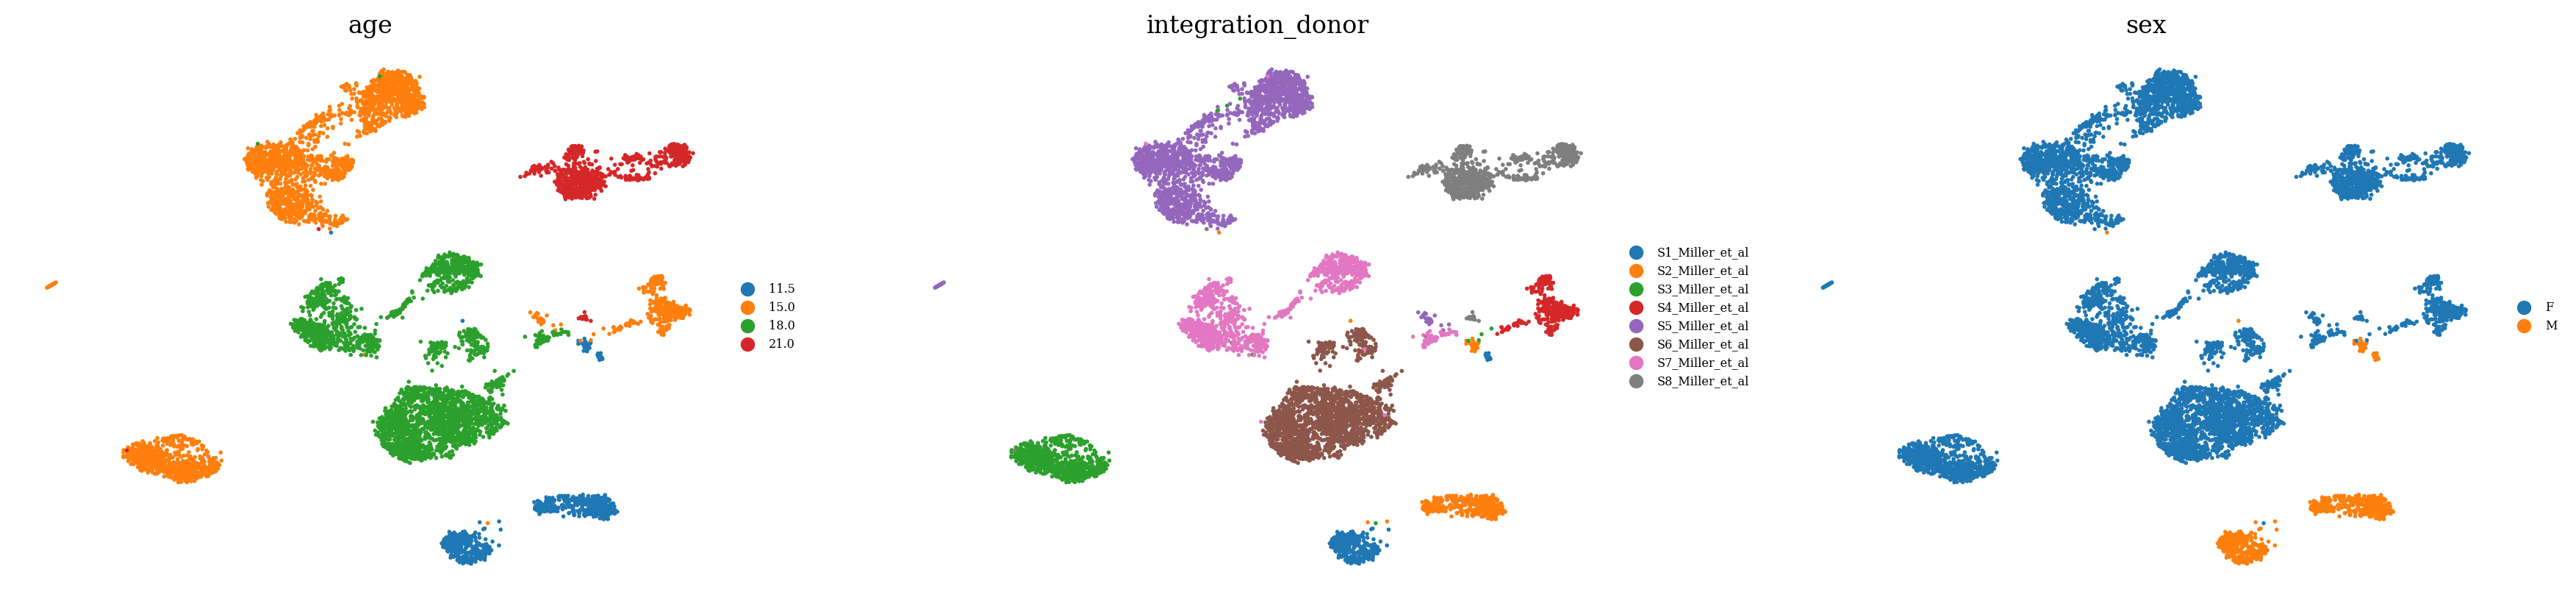

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

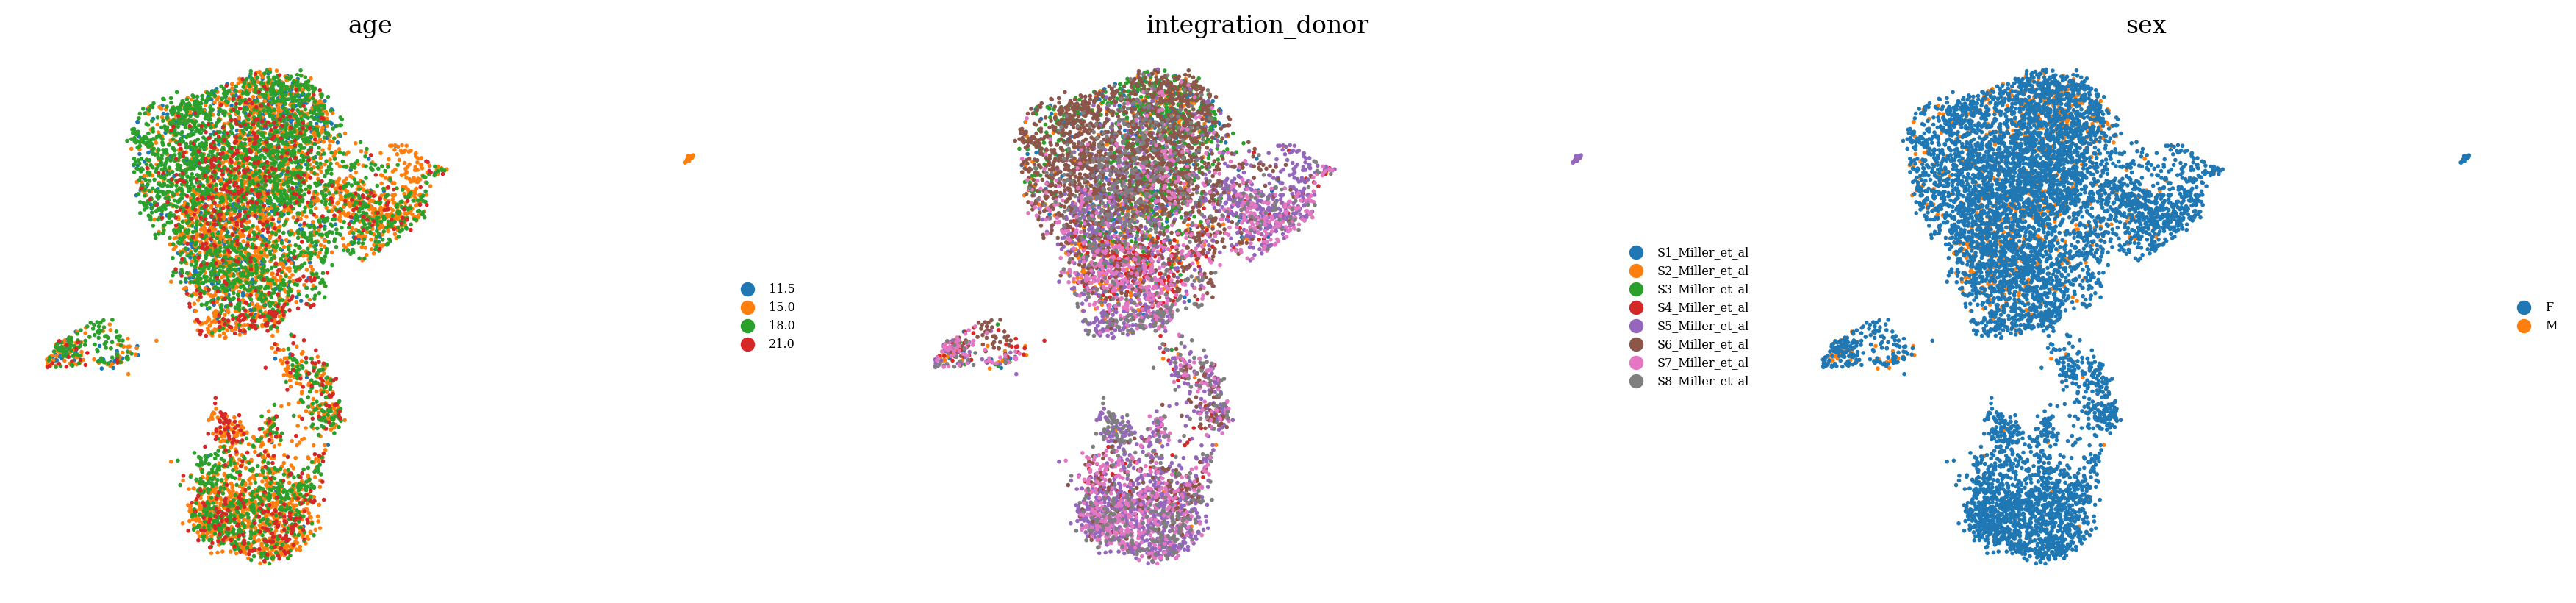

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 1/232 [00:00<00:57,  4.03it/s]

  7%|▋         | 17/232 [00:00<00:03, 60.68it/s]

 15%|█▌        | 35/232 [00:00<00:01, 100.72it/s]

 22%|██▏       | 52/232 [00:00<00:01, 120.42it/s]

 30%|███       | 70/232 [00:00<00:01, 137.13it/s]

 38%|███▊      | 88/232 [00:00<00:00, 148.60it/s]

 46%|████▌     | 106/232 [00:00<00:00, 156.27it/s]

 53%|█████▎    | 124/232 [00:00<00:00, 161.83it/s]

 61%|██████    | 142/232 [00:01<00:00, 166.13it/s]

 69%|██████▉   | 160/232 [00:01<00:00, 169.11it/s]

 77%|███████▋  | 178/232 [00:01<00:00, 171.15it/s]

 84%|████████▍ | 196/232 [00:01<00:00, 172.40it/s]

 92%|█████████▏| 214/232 [00:01<00:00, 172.86it/s]

100%|██████████| 232/232 [00:01<00:00, 98.87it/s] 

100%|██████████| 232/232 [00:01<00:00, 125.42it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.26589722419550976

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)